In [5]:
#ENTITY TYPE MANIPULATION AND ERROR ANALYSIS for ELC on ItsIRL model
"""
get ItsIRL ELC runs for modification/analysis 

See code repo "experiments/README.md" for how to finetune ItsIRL for task and get outputs needed

ELC:        PubMedBERT (2.3.9) 96.02   https://colab.research.google.com/drive/1CDwTG71UkTKLxMhk7uDm4DHX2YABYbEf#scrollTo=kG-RHug3lofO
          ITSIRL EndToEnd      95.73   debug_elc_0519_endtoend_noclipping_lr2e5)
          ITSIRL Decoder-only  91.95   debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5		 
        BIER   Sparse NN       87.5    BIERs paper        
"""
print()

In [6]:
#0. get data
#1. compare preds in table
#2. get ontology and inspection code
#3. load/edit FFN model and do manipulation experiments

In [7]:
!pip install -q transformers==4.18.0

# 0: Get data

In [8]:
import gdown

def download_data(gid, out, quiet=True):
  gdown.download("https://drive.google.com/uc?id="+gid, out, quiet)

e2e_out = "debug_elc_0519_endtoend_no_clipping_lr2e5_ep10_test_full_predictions.npy"
e2e_gid = "1d4k0gt5Bs8PmklscWI8Od0IplGzmPSRr"
download_data(e2e_gid, e2e_out)

p1_out = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_full_predictions.npy"
p1_gid = "1GSmhWFgmqMnv2IyQVf8hGF_KrQFYpFRL"
download_data(p1_gid, p1_out)

p2_out = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_true_labels.npy"
p2_gid = "1H80SThDzjcf1rtd0uTMJO6Sr-DD4SrvM"
download_data(p2_gid, p2_out)

p3_out = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000.pt"
p3_gid = "18eMlMUQLcr2b8fF9gHzplCu13remAskR"
download_data(p3_gid, p3_out, quiet=False)

# BASELINE ItsIRL model: 
p4_out = "0504_prior_ier_frozen_with_ffn_400000.pt"
p4_gid = "11ISgZPWOFOUyGctNtMqtt5hQsGZRMyjd"
download_data(p4_gid, p4_out, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=18eMlMUQLcr2b8fF9gHzplCu13remAskR
To: /content/debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000.pt
100%|██████████| 1.30G/1.30G [00:08<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=11ISgZPWOFOUyGctNtMqtt5hQsGZRMyjd
To: /content/0504_prior_ier_frozen_with_ffn_400000.pt
100%|██████████| 1.30G/1.30G [00:08<00:00, 158MB/s] 


In [9]:
!ls -laht

total 2.5G
drwxr-xr-x 1 root root 4.0K Jul  8 12:56 .
-rw-r--r-- 1 root root 1.3G Jul  8 12:56 0504_prior_ier_frozen_with_ffn_400000.pt
-rw-r--r-- 1 root root 1.3G Jul  8 12:56 debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000.pt
-rw-r--r-- 1 root root  55K Jul  8 12:55 debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_true_labels.npy
-rw-r--r-- 1 root root 435K Jul  8 12:55 debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_full_predictions.npy
-rw-r--r-- 1 root root 435K Jul  8 12:55 debug_elc_0519_endtoend_no_clipping_lr2e5_ep10_test_full_predictions.npy
drwxr-xr-x 1 root root 4.0K Jul  8 12:43 ..
drwxr-xr-x 1 root root 4.0K Jul  6 13:22 sample_data
drwxr-xr-x 4 root root 4.0K Jul  6 13:21 .config


# 1: Compare preds in table, etc

In [10]:
import glob
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

e2e_preds_file = "debug_elc_0519_endtoend_no_clipping_lr2e5_ep10_test_full_predictions.npy"
ffn_preds_file = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_full_predictions.npy"
true_preds_file = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_true_labels.npy"
ffn_model_file = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000.pt"

e2e_preds = np.load(e2e_preds_file)
ffn_preds = np.load(ffn_preds_file)
true_preds = np.load(true_preds_file)
print(e2e_preds.shape, ffn_preds.shape, true_preds.shape)  #(6955, 16) (6955, 16) (6955,)

(6955, 16) (6955, 16) (6955,)


In [11]:
def get_df(e2e_preds, ffn_preds, true_preds):
  res = []
  for i in range(true_preds.shape[0]):    
    try:
      e2e_pred = np.argmax(e2e_preds[i])    
      ffn_pred = np.argmax(ffn_preds[i])
      true_pred = true_preds[i]
      res.append([true_pred, e2e_pred, e2e_pred == true_pred, 
                ffn_pred, ffn_pred == true_pred, e2e_pred == ffn_pred,
                [ round(v,3) for v in e2e_preds[i]],
                [ round(v,3) for v in ffn_preds[i]]])
    except Exception as e:
      print("Error at i",i,e)
        
  return pd.DataFrame(res, columns=["label","e2e_pred","e2e_correct?","ffn_pred","ffn_correct?","ffn_eq_e2e", "e2e_preds","ffn_preds"])

df = get_df(e2e_preds, ffn_preds, true_preds)
df.head()

,label,e2e_pred,e2e_correct?,ffn_pred,ffn_correct?,ffn_eq_e2e,e2e_preds,ffn_preds
0,0,0,True,0,True,True,"[5.866, -3.167, -3.193, -3.488, -3.445, -3.057...","[7.828, -2.814, -5.429, -2.597, -1.947, -6.166..."
1,0,0,True,0,True,True,"[5.873, -3.124, -3.295, -3.477, -3.439, -2.983...","[8.171, -4.366, -6.372, -0.661, -3.316, -8.015..."
2,1,1,True,5,False,False,"[-3.562, 5.002, -3.109, -3.573, -3.634, -2.403...","[-9.166, 0.566, -3.79, -8.496, -6.765, 2.92, -..."
3,0,0,True,0,True,True,"[5.866, -3.114, -3.217, -3.505, -3.42, -3.066,...","[5.832, -2.872, -7.097, -0.978, -3.251, -5.114..."
4,0,0,True,0,True,True,"[5.87, -3.136, -3.241, -3.468, -3.474, -3.023,...","[5.42, -5.363, -2.926, 0.214, -3.596, -7.131, ..."


In [12]:
def show_table_analysis(df):
  e2e_true = df[df['e2e_correct?'] == True]
  e2e_false = df[df['e2e_correct?'] == False]
  ffn_true = df[df['ffn_correct?'] == True] 
  ffn_false = df[df['ffn_correct?'] == False] 

  print("E2E correct:", e2e_true.shape[0], "/", df.shape[0], "=", round(e2e_true.shape[0]/df.shape[0],4),
        "| E2E incorrect:", e2e_false.shape[0], "/", df.shape[0], "=", round(e2e_false.shape[0]/df.shape[0],4))
  print("FFN correct:", ffn_true.shape[0], "/", df.shape[0], "=", round(ffn_true.shape[0]/df.shape[0],4),
        "| FFN incorrect:", ffn_false.shape[0], "/", df.shape[0], "=", round(ffn_false.shape[0]/df.shape[0],4))
  print("=========================\n")

  ffn_eq_e2e = df[df['ffn_eq_e2e'] == True]
  ffn_eq_e2e_cor = df[(df['ffn_eq_e2e'] == True) & (df['e2e_correct?'] == True)]
  ffn_eq_e2e_incor = df[(df['ffn_eq_e2e'] == True) & (df['e2e_correct?'] == False)]

  print("Same Preds:", ffn_eq_e2e.shape[0] , "/", df.shape[0], "=", round(ffn_eq_e2e.shape[0] /df.shape[0],4))
  print("Same Preds and Correct:", ffn_eq_e2e_cor.shape[0] , "/", ffn_eq_e2e.shape[0] , "=", round(ffn_eq_e2e_cor.shape[0] /ffn_eq_e2e.shape[0] ,4))
  print("Same Preds and Incorrect:", ffn_eq_e2e_incor.shape[0] , "/", ffn_eq_e2e.shape[0] , "=", round(ffn_eq_e2e_incor.shape[0] /ffn_eq_e2e.shape[0] ,4))
  print("\n=========================")

  ffn_neq_e2e = df[df['ffn_eq_e2e'] == False]
  ffn_neq_e2e_cor = df[(df['ffn_eq_e2e'] == False) & (df['e2e_correct?'] == False) & (df['ffn_correct?'] == False)]
  ffn_neq_e2e_e2e_cor = df[(df['ffn_eq_e2e'] == False) & (df['e2e_correct?'] == True)]
  ffn_neq_e2e_ffn_cor = df[(df['ffn_eq_e2e'] == False) & (df['ffn_correct?'] == True)]

  #where e2e is right and ffn is wrong
  print("Diff Preds:", ffn_neq_e2e.shape[0] , "/", df.shape[0], "=", round(ffn_neq_e2e.shape[0] /df.shape[0],4))
  print("Diff Preds and E2E correct:", ffn_neq_e2e_e2e_cor.shape[0] , "/", ffn_neq_e2e.shape[0] , "=", round(ffn_neq_e2e_e2e_cor.shape[0] /ffn_neq_e2e.shape[0] ,4))
  print("Diff Preds and FFN correct:", ffn_neq_e2e_ffn_cor.shape[0] , "/", ffn_neq_e2e.shape[0] , "=", round(ffn_neq_e2e_ffn_cor.shape[0] /ffn_neq_e2e.shape[0] ,4))
  print("Diff Preds and Both Incorrect:", ffn_neq_e2e_cor.shape[0] , "/", ffn_neq_e2e.shape[0] , "=", round(ffn_neq_e2e_cor.shape[0] /ffn_neq_e2e.shape[0] ,4))

  return [e2e_true, e2e_false, ffn_true, ffn_false, 
          ffn_eq_e2e, ffn_eq_e2e_cor, ffn_eq_e2e_incor,
          ffn_neq_e2e, ffn_neq_e2e_cor, ffn_neq_e2e_e2e_cor, ffn_neq_e2e_ffn_cor]

res = show_table_analysis(df)

E2E correct: 6648 / 6955 = 0.9559 | E2E incorrect: 307 / 6955 = 0.0441
FFN correct: 6363 / 6955 = 0.9149 | FFN incorrect: 592 / 6955 = 0.0851

Same Preds: 6440 / 6955 = 0.926
Same Preds and Correct: 6285 / 6440 = 0.9759
Same Preds and Incorrect: 155 / 6440 = 0.0241

Diff Preds: 515 / 6955 = 0.074
Diff Preds and E2E correct: 363 / 515 = 0.7049
Diff Preds and FFN correct: 78 / 515 = 0.1515
Diff Preds and Both Incorrect: 74 / 515 = 0.1437


# 2a: get ELC labels, test data & ontology

In [13]:
!ls elc_data/

ls: cannot access 'elc_data/': No such file or directory


In [14]:
#2a. 
!rm -rf elc_data
!mkdir elc_data

download_data("1a2ZzlougPY5ROdEKvTJzvNE_yr0Omizh", "elc_data/BioNLP-ST_2013_CG_training_data.tar")
download_data("1q-LxC3erVY70MJXZhZGkxSsOPrqX6Kts", "elc_data/BioNLP-ST_2013_CG_development_data.tar")
download_data("1kreQb3zYjwCiUtefB4D30uoDNjrnyu17", "elc_data/BioNLP-ST_2013_CG_test_data.tar")
!cd elc_data && tar -xf BioNLP-ST_2013_CG_training_data.tar
!cd elc_data && tar -xf BioNLP-ST_2013_CG_development_data.tar
!cd elc_data && tar -xf BioNLP-ST_2013_CG_test_data.tar

In [15]:
def get_mentions(ids):
  mentions = {}
  for a1file in ids:
    pmid = a1file.split("/")[-1].split(".")[0]    
    pm_txtfile = "/".join(a1file.split("/")[0:-1]) + "/" + pmid + ".txt"
    with open(a1file) as f:
      lines = [ [ t.strip("\n") for t in l.split("\t")] for l in f.readlines() ]  
    with open(pm_txtfile) as f:
      title, abstract = f.readlines()    
    mentions[pmid] = [title.strip("\n"), abstract.strip("\n"), lines]
  return mentions

#test_ids = glob.glob('./elc_data/BioNLP-ST_2013_CG_test_data/PMID-*.a1')       

#use next to maintain testid order with e2e from server
test_ids = ['./elc_data/BioNLP-ST_2013_CG_test_data/PMID-9490736.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12201487.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-21483806.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19148483.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16455654.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7120085.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7686447.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-22429855.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-22614711.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15965284.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2464672.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19556134.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18554547.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10348440.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19295129.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12138191.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16691484.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18646688.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12558942.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15041728.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-6744243.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19164985.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-6084300.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10461060.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18502145.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12962723.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17851915.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8564850.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12209602.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19471112.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19956847.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-6156133.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7779866.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18761658.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19091459.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8736173.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17178599.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8844727.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-3325878.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15217612.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-21084727.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20061129.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17199697.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-1670994.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17492673.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12872134.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-21858812.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19109168.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12779350.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2213113.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15266333.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10688644.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-1370299.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18376140.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12369594.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17640057.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18499889.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8634981.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11577003.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19632988.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9045885.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15774527.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-14576200.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12540483.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19576624.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12075162.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10979970.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7543020.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-3934707.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12622417.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7794272.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-21683672.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17551815.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18980679.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-21853499.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20112043.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12084351.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17909628.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18581207.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11749071.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7585733.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19764591.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16981245.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19540587.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9562977.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10984714.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8084600.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19771241.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18564172.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8062825.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2514403.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12198766.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17967875.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19223494.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12388106.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11311231.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16397229.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7420025.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20353786.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18953546.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20978192.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16585210.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16934444.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7505952.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19098000.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10470095.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19152650.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18566344.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16406506.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-6095116.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-6378935.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-3118962.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15865939.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9390137.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11480035.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18789152.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17762973.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19721007.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12090046.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17285974.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9428378.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18945211.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11859873.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19767769.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18922934.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10811911.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19219913.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15494684.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19360900.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16341007.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11107747.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10385711.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11948691.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2427928.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19351751.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2538232.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12958070.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19812364.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17440699.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17578706.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15033782.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18030875.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18829527.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8691350.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19570906.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15590693.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16809768.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8657764.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10657950.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11824472.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12935890.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11856141.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9864390.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12096842.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17404823.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-14767510.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-22315407.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20565704.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17130843.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12152164.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9233832.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9199203.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2187437.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8489886.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-10758166.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8433010.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11773437.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16858650.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11419822.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17533366.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18826258.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9727438.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9852401.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15535839.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19917848.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19208839.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20392988.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-15243804.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-17505508.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16438941.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9891063.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-14597675.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-9020068.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-20814749.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18301249.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18413757.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-14633695.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-16144215.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12852503.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18413367.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-22318232.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-19623159.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-2407842.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-11815955.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12235242.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-12766067.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8344624.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-18172308.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-8602617.a1', './elc_data/BioNLP-ST_2013_CG_test_data/PMID-7475551.a1']
test_data = get_mentions(test_ids)

label_map = {'Gene_or_gene_product': 0, 'Cell': 1, 'Cancer': 2, 'Simple_chemical': 3,  
              'Organism': 4, 'Multi-tissue_structure': 5, 'Tissue': 6, 'Cellular_component': 7, 
              'Organ': 8, 'Pathological_formation': 9, 'Organism_substance': 10, 'Amino_acid': 11, 
              'Immaterial_anatomical_entity': 12, 'Organism_subdivision': 13, 'Anatomical_system': 14, 
              'Developing_anatomical_structure': 15}

In [16]:
#2. get ontology 
# GET biomedical entity type system
!rm -rf ontology/
!mkdir ontology
!cd ontology && wget https://raw.githubusercontent.com/diegoolano/biomedical_interpretable_entity_representations/main/ier_model/ontology/medwiki_types_721_600k_full.txt
!ls ontology/

--2022-07-08 12:56:47--  https://raw.githubusercontent.com/diegoolano/biomedical_interpretable_entity_representations/main/ier_model/ontology/medwiki_types_721_600k_full.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1492327 (1.4M) [text/plain]
Saving to: ‘medwiki_types_721_600k_full.txt’

medwiki_types_721_6 100%[===================>]   1.42M  --.-KB/s    in 0.05s   

2022-07-08 12:56:47 (26.1 MB/s) - ‘medwiki_types_721_600k_full.txt’ saved [1492327/1492327]

medwiki_types_721_600k_full.txt


In [17]:
!mkdir out
!ls

0504_prior_ier_frozen_with_ffn_400000.pt
debug_elc_0519_endtoend_no_clipping_lr2e5_ep10_test_full_predictions.npy
debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_full_predictions.npy
debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ep200_test_true_labels.npy
debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000.pt
elc_data
ontology
out
sample_data


#2b. get loading data related code

In [18]:
#2b. get data loading/inspection/model related code

def get_test_data(model, test_pmids, test_data, label_map, max_len=512):
  st = time.time()
  test_input_ids, test_attention_masks = [], []
  test_labels = []
  test_info = []
  test_texts = []
  
  if 'irl_model' in dir(model):
    tokenizer = model.irl_model.transformer_tokenizer
  else:
    tokenizer = model.transformer_tokenizer

  for i, pmid in enumerate(test_pmids):
    tmp_pmid = "PMID" + pmid.split("PMID")[1]
    pmid = tmp_pmid.split(".")[0]
    exs = test_data[pmid]
    title = exs[0]
    abstract = exs[1]
    mentions = exs[2]
    for m in mentions:
      torch.cuda.empty_cache()
      mention = m[2]
      abstract_txt = abstract
      label, start, end = m[1].split(" ") 
      context_tokens = tokenizer.encode_plus(mention,abstract_txt)
      cur_len = len(context_tokens['input_ids'])
      encoded_dict = tokenizer.encode_plus(    
            mention,abstract_txt,
            add_special_tokens=True,
            max_length=max_len,
            truncation_strategy='only_second',
            pad_to_max_length=True,
            return_tensors='pt'
          )
      test_input_ids.append(encoded_dict['input_ids'][0])
      test_attention_masks.append(encoded_dict['attention_mask'][0]) 
      test_labels.append(label_map[label])
      test_info.append([pmid,m[0]])
      test_texts.append(mention + "<SEP>" + abstract_txt)
  
  
  # Convert the lists into PyTorch tensors.
  test_pt_input_ids = torch.stack(test_input_ids, dim=0)
  test_pt_attention_masks = torch.stack(test_attention_masks, dim=0)
  test_pt_labels = torch.tensor(test_labels, dtype=torch.long)  
  
  # Set the batch size and # Create the DataLoader for our testing set.
  test_batch_size = 1
  test_prediction_data = TensorDataset(test_pt_input_ids, test_pt_attention_masks, test_pt_labels)
  test_prediction_sampler = SequentialSampler(test_prediction_data)
  test_prediction_dataloader = DataLoader(test_prediction_data, sampler=test_prediction_sampler, batch_size=test_batch_size)
  print("Elapsed.", time.time() - st)   #50 seconds

  return test_prediction_dataloader, test_texts


def flat_accuracy(preds, labels):
  pred_flat = preds.flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


def do_test(pmodel, test_prediction_dataloader, model_id, device, label_map ):
  #Eval test 
  t0 = time.time()
  print("Evaling ", model_id)
  test_predictions , test_true_labels, et_preds  = [], [], []
  pmodel.eval()
  for tbatch in test_prediction_dataloader:
    tbatch = tuple(t.to(device) for t in tbatch)
    test_b_input_ids, test_b_input_mask, test_b_labels = tbatch
  
    with torch.no_grad():
      torch.cuda.empty_cache()

      test_inputs = {'input_ids': test_b_input_ids, 'token_type_ids': None, 'attention_mask': test_b_input_mask}
      test_outputs = pmodel(test_inputs)      

      entity_type_logits = test_outputs[1]
      entity_types = entity_type_logits.detach().cpu().numpy()
      et_preds.append(entity_types)

      test_logits = test_outputs[2]   
      test_logits = test_logits.detach().cpu().numpy()
  
      test_label_ids = test_b_labels.to('cpu').numpy()
      test_predictions.append(test_logits)
      test_true_labels.append(test_label_ids)

  t_all_predictions = np.concatenate(test_predictions, axis=0)
  t_all_true_labels = np.concatenate(test_true_labels, axis=0)
  t_predicted_label_ids = np.argmax(t_all_predictions, axis=1)
  t_predicted_label_probs = np.max(t_all_predictions, axis=1)
  t_all_et_preds = np.concatenate(et_preds, axis=0)

  print(t_all_predictions.shape, t_all_true_labels.shape, t_predicted_label_ids.shape)  #(6955, 16) (6955,) (6955,), (8 x 63808 )
  test_acc = flat_accuracy(t_predicted_label_ids , t_all_true_labels) 

  print("Done Testing. Elapsed:", time.time() - t0)
  print("Test acc:", test_acc)
 
  id2label = { label_map[l]:l for l in list(label_map.keys()) } 
  true_ls = [ id2label[a] for a in list(t_all_true_labels.flatten())]
  pred_ls = [ id2label[a] for a in list(t_predicted_label_ids.flatten())]
  correct = [ v == pred_ls[i] for i,v in enumerate(true_ls)]

  md = [true_ls, pred_ls, list(t_predicted_label_probs.flatten()),correct ]
  my_data = [ [md[0][i], md[1][i], md[2][i], md[3][i]] for i in range(len(true_ls)) ]
  #df = pd.DataFrame(my_data, columns=["true label", "pred_label", "pred_prob", "correct?"])

  # save out results
  # outfile = "out/test_"+model_id+"_ep"+str(cur_epoch)+"_res.pkl"
  # with open(outfile, 'wb') as fp:
  #  pickle.dump(my_data, fp)

  print("Saving out results to out/ with prefix ",model_id)
  np.save("out/"+model_id+"_test_full_predictions.npy", t_all_predictions)
  np.save("out/"+model_id+"_test_true_labels.npy", t_all_true_labels)
  np.save("out/"+model_id+"_test_single_predictions.npy", t_predicted_label_ids)
  np.save("out/"+model_id+"_test_single_pred_probs.npy", t_predicted_label_probs)
  np.save("out/"+model_id+"_test_single_entity_types.npy", t_all_et_preds)

  return my_data

# 2c: model related code

In [19]:
TRANSFORMER_MODELS = {
  'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext': (AutoModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'), AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'))
}

class SimpleDecoder(nn.Module):
  def __init__(self, output_dim, answer_num):
    super(SimpleDecoder, self).__init__()
    self.answer_num = answer_num
    self.linear = nn.Linear(output_dim, answer_num, bias=False)

  def forward(self, inputs, output_type=None):
    output_embed = self.linear(inputs)
    return output_embed


class DownProject(nn.Module):
  def __init__(self, output_dim, answer_num):
    super(DownProject, self).__init__()
    self.answer_num = answer_num
    self.linear = nn.Linear(answer_num, output_dim, bias=False)

  def forward(self, inputs, output_type=None):
    output_embed = self.linear(inputs)
    return output_embed


class IERDecoder(nn.Module):
  def __init__(self, output_dim, dropout_rate=.1):
    super(IERDecoder, self).__init__()    
    self.linear = nn.Linear(output_dim, output_dim, bias=False)
    self.layer_norm = nn.LayerNorm(output_dim)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, inputs, output_type=None):
    output_embed = self.linear(inputs)
    output_embed = self.layer_norm(output_embed)
    output_embed = self.dropout(output_embed)        
    return output_embed


class PriorModelBase(nn.Module):
  def __init__(self):
    super(PriorModelBase, self).__init__()
    self.type_loss = nn.BCEWithLogitsLoss()
    self.sigmoid_fn = nn.Sigmoid()
    self.mse_loss = nn.MSELoss()

  def define_loss(self, logits, targets, bert_cls, ier_layer):
    #this is reconstruction loss between output logits and the initial BERT cls rep
    mse_err = self.mse_loss(logits, bert_cls) 

    #this is the entity typing loss over the sparse layer and entity type labels
    type_err = self.type_loss(ier_layer, targets)
    return [mse_err, type_err]

  def forward(self, feed_dict):
    pass

class PriorTransformerModelwithFFN(PriorModelBase):
  def __init__(self, answer_num):
    super(PriorTransformerModelwithFFN, self).__init__()
    model_type = 'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'
    hidden_dropout_prob = .1
    print('In PriorTransformerModelwithFFN Initializing <{}> model...'.format(model_type))
    _model_class, _tokenizer_class = TRANSFORMER_MODELS[model_type]
    self.transformer_tokenizer = _tokenizer_class.from_pretrained(model_type)
    self.transformer_config = AutoConfig.from_pretrained(model_type)
    self.encoder = _model_class.from_pretrained(model_type)
    self.classifier = SimpleDecoder(self.transformer_config.hidden_size, answer_num)
    self.dropout = nn.Dropout(hidden_dropout_prob)
    self.avg_pooling = False
    self.freeze_ier = True
    self.et_lambda = 0
    self.num_ff_layers = 3

    hidden_size = self.transformer_config.hidden_size
    dropout_rate = hidden_dropout_prob

    self.down_project =  DownProject(hidden_size, answer_num)
    print("USE Decoder with ",self.num_ff_layers," layers ")
    self.decoder_l1 = IERDecoder(hidden_size, dropout_rate)
    self.decoder_l2 = IERDecoder(hidden_size, dropout_rate)
    self.decoder_l3 = IERDecoder(hidden_size, dropout_rate)

    # if freeze is True, hold encoder/classifier as is and then only do updates to weights for ffn layers
    if self.freeze_ier:
      for param in self.encoder.parameters():
        param.requires_grad = False
      for param in self.classifier.parameters():
        param.requires_grad = False 

      self.et_lambda = 0 # if we are freezing prior model, we really only want to optimize for MSE ( since by this point ET has been optimized for already )

  def forward(self, inputs, targets=None, fix_types=None, promote_types=None, mult=1):
    outputs = self.encoder(
      inputs["input_ids"],
      attention_mask=inputs["attention_mask"],
      token_type_ids=inputs["token_type_ids"] if "token_type_ids" in inputs else (None)
    )
    if self.avg_pooling:  # Averaging all hidden states
      orig_outputs = (outputs[0] * inputs["attention_mask"].unsqueeze(-1)).sum(1)\
                / inputs["attention_mask"].sum(1).unsqueeze(-1)
    else:  # Use [CLS]
      orig_outputs = outputs[0][:, 0, :]

    #2. do dropout on output of encoder (CLS by default)
    orig_outputs_drop = self.dropout(orig_outputs)

    #3. pass through linear layer to get interpretable sparse layer (ie, prior logits)  
    #this layer has not been transformed via sigmoid to keep logits unbounded!
    ier_layer = self.classifier(orig_outputs_drop)

    if fix_types != None or promote_types != None:
      ier_np = ier_layer.clone().detach().cpu().numpy()
      #print("IER to fix/promote: ", ier_np[0:20])      
      use_max = float(np.max(ier_np)) * mult
      if use_max < 0:
        use_max = use_max * -1

      #use_min = float(torch.min(ier_layer).detach().cpu()) * mult
      use_min = float(np.min(ier_np)) * mult

    if fix_types != None:
      fix_types = fix_types.detach().cpu().numpy()      
      #print("Fix types with ", use_min)
      for et_end in fix_types:  
        ier_layer[0,int(et_end)] = use_min 
    
    if promote_types != None:
      promote_types = promote_types.detach().cpu().numpy()      
      #print("Promote types with ", use_max)
      for et_end in promote_types:  
        ier_layer[0,int(et_end)] = use_max
      
    #4. new pass through linear layer returning to 768 embedding size expected by BERT
    down_project = self.down_project(ier_layer)

    #5. feed downprojected sparse layer into BERT encoder ( feed in embeddings)
    outputs_l1 = self.decoder_l1(down_project)
    outputs_l2 = self.decoder_l2(outputs_l1)
    outputs_l3 = self.decoder_l3(outputs_l2)
    logits = outputs_l3

    if targets is not None:
      mse_err, type_err = self.define_loss(logits, targets, orig_outputs, ier_layer)
    else:      
      mse_err, type_err = None, None

    #return mse_err, type_err, orig_outputs_drop, logits, ier_layer
    return mse_err, type_err, logits, ier_layer

class PTMFlinear(nn.Module):
  def __init__(self, model, num_labels, freeze_mod=True):
    super(PTMFlinear, self).__init__()
    self.num_labels = num_labels
    self.sigmoid_fn = nn.Sigmoid()
    self.loss_fn = nn.CrossEntropyLoss() 
    self.irl_model = model
    self.label_classifier = nn.Linear(model.transformer_config.hidden_size, num_labels)

    if freeze_mod != "endtoend":
      print("FREEZING IER LAYERS")
      #IER weights are frozen if not endtoend!
      for param in self.irl_model.encoder.parameters():
        param.requires_grad = False
      for param in self.irl_model.classifier.parameters():
        param.requires_grad = False 

  def forward(self, inputs, targets=None, labels=None, fix_types=None, promote_types=None, mult=1):
    _, _, logits, ier_layer = self.irl_model(inputs, targets, fix_types, promote_types, mult)
    sig_logits = self.sigmoid_fn(logits) 
    label_logits = self.label_classifier(sig_logits)
    if labels is not None:
      loss = self.loss_fn(label_logits.view(-1, self.num_labels), labels.view(-1))
    else:
      loss = None
    return loss, ier_layer, label_logits, sig_logits



def load_model(reload_model_name, save_dir, model_id, model,
               optimizer_enc=None, optimizer_cls=None, scheduler_enc=None, scheduler_cls=None):
  if reload_model_name:
    model_file_name = '{0:s}/{1:s}.pt'.format(save_dir, reload_model_name)
  else:
    model_file_name = '{0:s}/{1:s}.pt'.format(save_dir, model_id)
  print("Loading ", model_file_name)
  checkpoint = torch.load(model_file_name)
  model.load_state_dict(checkpoint['state_dict'], strict=False)

  if len(model.state_dict()) != len(checkpoint['state_dict']):
    print("Size expected vs state_dict size passed in ", len(model.state_dict()), len(checkpoint['state_dict']))

  if optimizer_enc and optimizer_cls:  # Continue training
    print("CHECKPOINT Optim Enc", checkpoint['optimizer_enc'].keys())
    optimizer_enc.load_state_dict(checkpoint['optimizer_enc'])
    optimizer_cls.load_state_dict(checkpoint['optimizer_cls'])
  else: 
    #otherwise don't load optimizer weights
    total_params = 0
    # Log params
    for k in checkpoint['state_dict']:
      elem = checkpoint['state_dict'][k]
      param_s = 1
      for size_dim in elem.size():
        param_s = size_dim * param_s
      #print(k, elem.size())
      total_params += param_s
    param_str = ('Number of total parameters..{0:d}'.format(total_params))
    print(param_str)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/221k [00:00<?, ?B/s]

# 3: load/edit FFN model

In [20]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [21]:
!wc -l ontology/medwiki_types_721_600k_full.txt

68304 ontology/medwiki_types_721_600k_full.txt


In [22]:
mod1 = "0504_prior_ier_frozen_with_ffn_400000"
mod2 = "debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000"

model_id = '0608_v3_ft_'  #IMPORTANT set this to whatever you want for saving out purposes of test inference
model = PriorTransformerModelwithFFN( 68304)
load_model(mod1, "./", model_id, model)   
test_prediction_dataloader, test_texts = get_test_data(model, test_ids, test_data, label_map)

pmodel = PTMFlinear(model, num_labels=16, freeze_mod=True)
load_model(mod2, "./", model_id, pmodel)   

pmodel.to(device)

my_data = do_test(pmodel, test_prediction_dataloader, model_id, device, label_map )


print()

In PriorTransformerModelwithFFN Initializing <microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext> model...


Some weights of the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


USE Decoder with  3  layers 
Loading  .//0504_prior_ier_frozen_with_ffn_400000.pt


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of total parameters..216171776


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Elapsed. 13.777513265609741
FREEZING IER LAYERS
Loading  .//debug_elc_0523_v1_ft_softmax_200eps_bothon_load_optimizers_enc_cls_ffn2e5_ffn_with_softmax_0504_prior_ier_frozen_with_ffn_400000.pt
Number of total parameters..216184080
Evaling  0608_v3_ft_
(6955, 16) (6955,) (6955,)
Done Testing. Elapsed: 155.66018795967102
Test acc: 0.9148813803019411
Saving out results to out/ with prefix  0608_v3_ft_



In [23]:
!ls -laht out/0608_v3_ft_*

-rw-r--r-- 1 root root 1.8G Jul  8 13:00 out/0608_v3_ft__test_single_entity_types.npy
-rw-r--r-- 1 root root 435K Jul  8 13:00 out/0608_v3_ft__test_full_predictions.npy
-rw-r--r-- 1 root root  55K Jul  8 13:00 out/0608_v3_ft__test_single_predictions.npy
-rw-r--r-- 1 root root  28K Jul  8 13:00 out/0608_v3_ft__test_single_pred_probs.npy
-rw-r--r-- 1 root root  55K Jul  8 13:00 out/0608_v3_ft__test_true_labels.npy


# 3b: counterfactual analysis, etc

## 0 get data in format / confusion maps / etc

In [24]:
cur_ffn_ets = np.load("out/0608_v3_ft__test_single_entity_types.npy")
cur_ffn_preds = np.load("out/0608_v3_ft__test_full_predictions.npy")
cur_true_preds = np.load("out/0608_v3_ft__test_true_labels.npy")
cur_df = get_df(e2e_preds, cur_ffn_preds, true_preds)   
#res = show_table_analysis(cur_df)

In [25]:
cur_df.head(2) 

,label,e2e_pred,e2e_correct?,ffn_pred,ffn_correct?,ffn_eq_e2e,e2e_preds,ffn_preds
0,0,0,True,0,True,True,"[5.866, -3.167, -3.193, -3.488, -3.445, -3.057...","[7.828, -2.814, -5.429, -2.597, -1.947, -6.166..."
1,0,0,True,0,True,True,"[5.873, -3.124, -3.295, -3.477, -3.439, -2.983...","[8.171, -4.366, -6.372, -0.661, -3.316, -8.015..."


In [26]:
#NOW add test_id , mention and context to each row
to_add = []
for i, pmid in enumerate(test_ids):
  tmp_pmid = "PMID" + pmid.split("PMID")[1]
  pmid = tmp_pmid.split(".")[0]
  exs = test_data[pmid]
  title = exs[0]
  abstract = exs[1]
  mentions = exs[2]
  for m in mentions:
    mention = m[2]
    label, start, end = m[1].split(" ") 
    to_add.append([pmid,mention,label,start,end,abstract])

to_add_df = pd.DataFrame(to_add, columns=["pmid","mention","label_txt","start","end","abstract"])
combined_df = pd.concat([cur_df, to_add_df], axis = 1)
combined_df.head(2)

,label,e2e_pred,e2e_correct?,ffn_pred,ffn_correct?,ffn_eq_e2e,e2e_preds,ffn_preds,pmid,mention,label_txt,start,end,abstract
0,0,0,True,0,True,True,"[5.866, -3.167, -3.193, -3.488, -3.445, -3.057...","[7.828, -2.814, -5.429, -2.597, -1.947, -6.166...",PMID-9490736,Integrin alphavbeta3,Gene_or_gene_product,0,20,Angiogenesis depends on growth factors and vas...
1,0,0,True,0,True,True,"[5.873, -3.124, -3.295, -3.477, -3.439, -2.983...","[8.171, -4.366, -6.372, -0.661, -3.316, -8.015...",PMID-9490736,mitogen-activated protein kinase,Gene_or_gene_product,47,79,Angiogenesis depends on growth factors and vas...


In [27]:
id2label = ["" for _ in label_map]
for v in label_map:
  id2label[label_map[v]] = v

for i,v in enumerate(id2label):
  print(i, v)
  
combined_df['e2e_pred_txt'] = [id2label[v] for v in combined_df['e2e_pred'].values]
combined_df['ffn_pred_txt'] = [id2label[v] for v in combined_df['ffn_pred'].values]
res = show_table_analysis(combined_df)
e2e_true, e2e_false, ffn_true, ffn_false, ffn_eq_e2e, ffn_eq_e2e_cor, ffn_eq_e2e_incor,ffn_neq_e2e, ffn_neq_e2e_cor, ffn_neq_e2e_e2e_cor, ffn_neq_e2e_ffn_cor = res

0 Gene_or_gene_product
1 Cell
2 Cancer
3 Simple_chemical
4 Organism
5 Multi-tissue_structure
6 Tissue
7 Cellular_component
8 Organ
9 Pathological_formation
10 Organism_substance
11 Amino_acid
12 Immaterial_anatomical_entity
13 Organism_subdivision
14 Anatomical_system
15 Developing_anatomical_structure
E2E correct: 6648 / 6955 = 0.9559 | E2E incorrect: 307 / 6955 = 0.0441
FFN correct: 6363 / 6955 = 0.9149 | FFN incorrect: 592 / 6955 = 0.0851

Same Preds: 6440 / 6955 = 0.926
Same Preds and Correct: 6285 / 6440 = 0.9759
Same Preds and Incorrect: 155 / 6440 = 0.0241

Diff Preds: 515 / 6955 = 0.074
Diff Preds and E2E correct: 363 / 515 = 0.7049
Diff Preds and FFN correct: 78 / 515 = 0.1515
Diff Preds and Both Incorrect: 74 / 515 = 0.1437


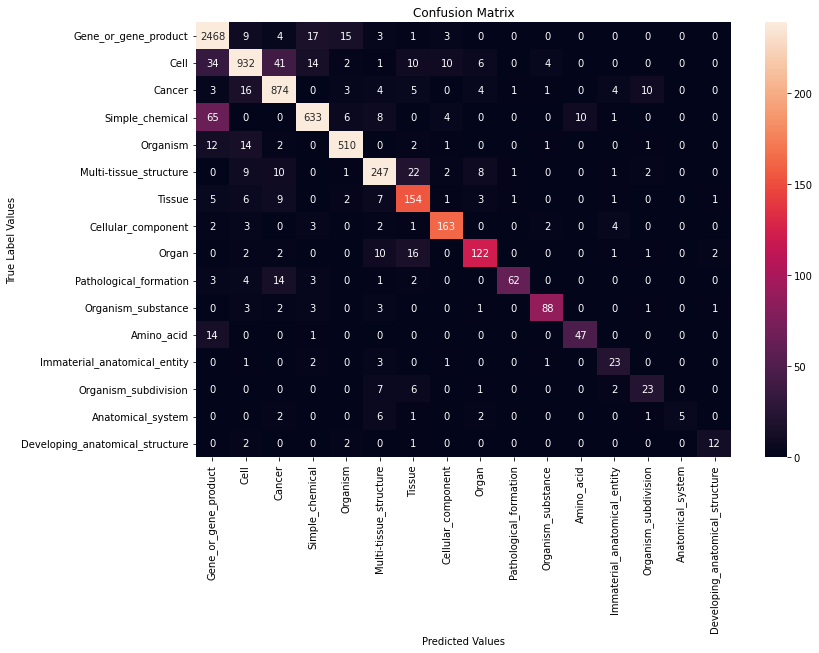

In [28]:
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def show_confusion(true_labels, pred_labels, save_name=None):
  cm = confusion_matrix(true_labels, pred_labels, labels=id2label)
  cm_df = pd.DataFrame(cm,index = id2label, columns = id2label)

  plt.figure(figsize=(12,8))
  sns.heatmap(cm_df, annot=True, fmt='g', robust=True)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label Values')
  plt.xlabel('Predicted Values')
  
  if save_name != None:
    #plt.gcf().subplots_adjust(bottom=0.15)

    plt.savefig(save_name,bbox_inches="tight")  

  plt.show()
  return cm_df

cm_df = show_confusion(combined_df['label_txt'].values, combined_df['ffn_pred_txt'].values,'confusion_mat_test_ffn_prefix_v2.pdf')

In [29]:
#insights from above:
#Cell is most likely to get misclassified as Cancer (40) and then Gene_or_gene_product (30) out of 1054
#Cancer is most likely to get misclassified as Cell (24) and then Organism_subdivision (10) out of 925
#Gene_or_gene_product is most likely to get misclassified as Organism (19) and Simple Chemical (15) out of 2520
#Simple Chemical is most likely to get misclassified as Gene_or_gene_product (68) out of 727
#Organism is most likely to get misclassified as Gene_or_gene_product (13) and then Cell (12)  out of 543
#Multitissue structure is most likely to get misclassifed as Tissue (20) and then Cancer (13) out of 303
#

#print(combined_df.label_txt.value_counts())  #sanity check passes
#precision = tp / (tp + fp)    AND recall = tp / fp + fn
from sklearn.metrics import precision_recall_fscore_support
def get_metrics_df(true_labels, pred_labels):
  p,r,f1,sup = precision_recall_fscore_support(true_labels, pred_labels, 
                                  average=None, labels=id2label)
  p = [100*round(v,4) for v in p]
  r = [100*round(v,4) for v in r]
  f1 = [100*round(v,4) for v in f1]
  return pd.DataFrame([p,r,f1,sup], columns = [v[0:5] for v in id2label], index = ["precision","recall","f1","support"])
met_df = get_metrics_df(combined_df['label_txt'].values, combined_df['ffn_pred_txt'].values)
met_df

,Gene_,Cell,Cance,Simpl,Organ,Multi,Tissu,Cellu,Organ,Patho,Organ,Amino,Immat,Organ,Anato,Devel
precision,94.70,93.11,91.04,93.64,94.27,81.79,69.68,88.11,82.99,95.38,90.72,82.46,62.16,58.97,100.00,75.00
recall,97.94,88.43,94.49,87.07,93.92,81.52,81.05,90.56,78.21,69.66,86.27,75.81,74.19,58.97,29.41,70.59
f1,96.29,90.71,92.73,90.24,94.10,81.65,74.94,89.32,80.53,80.52,88.44,78.99,67.65,58.97,45.45,72.73
support,2520.00,1054.00,925.00,727.00,543.00,303.00,190.00,180.00,156.00,89.00,102.00,62.00,31.00,39.00,17.00,17.00


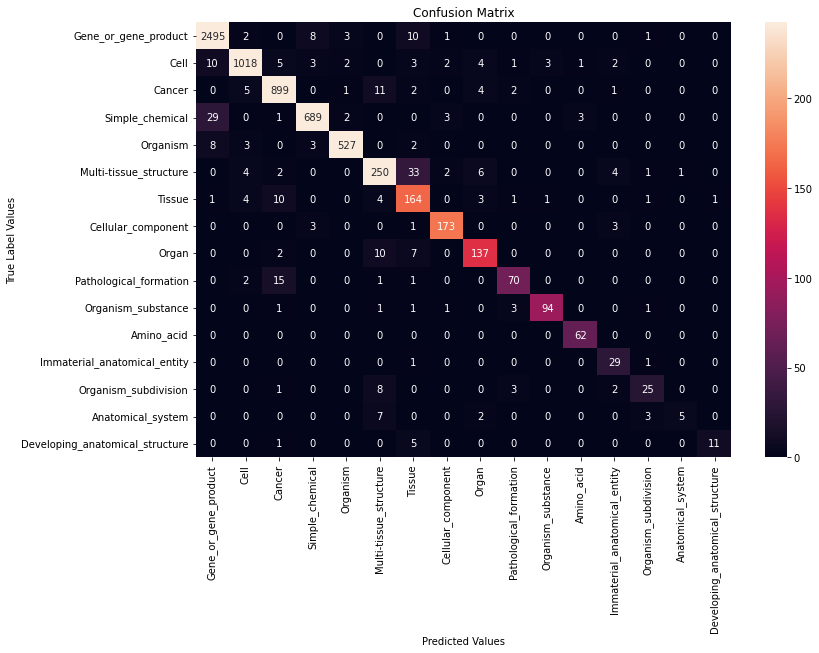

,Gene_or_gene_product,Cell,Cancer,Simple_chemical,Organism,Multi-tissue_structure,Tissue,Cellular_component,Organ,Pathological_formation,Organism_substance,Amino_acid,Immaterial_anatomical_entity,Organism_subdivision,Anatomical_system,Developing_anatomical_structure
Gene_or_gene_product,2495,2,0,8,3,0,10,1,0,0,0,0,0,1,0,0
Cell,10,1018,5,3,2,0,3,2,4,1,3,1,2,0,0,0
Cancer,0,5,899,0,1,11,2,0,4,2,0,0,1,0,0,0
Simple_chemical,29,0,1,689,2,0,0,3,0,0,0,3,0,0,0,0
Organism,8,3,0,3,527,0,2,0,0,0,0,0,0,0,0,0
Multi-tissue_structure,0,4,2,0,0,250,33,2,6,0,0,0,4,1,1,0
Tissue,1,4,10,0,0,4,164,0,3,1,1,0,0,1,0,1
Cellular_component,0,0,0,3,0,0,1,173,0,0,0,0,3,0,0,0
Organ,0,0,2,0,0,10,7,0,137,0,0,0,0,0,0,0
Pathological_formation,0,2,15,0,0,1,1,0,0,70,0,0,0,0,0,0


In [30]:
#comparing above to e2e preds
show_confusion(combined_df['label_txt'].values, combined_df['e2e_pred_txt'].values)

In [31]:
met_df_ece = get_metrics_df(combined_df['label_txt'].values, combined_df['e2e_pred_txt'].values)
met_df_ece

,Gene_,Cell,Cance,Simpl,Organ,Multi,Tissu,Cellu,Organ,Patho,Organ,Amino,Immat,Organ,Anato,Devel
precision,98.11,98.07,95.94,97.59,98.50,85.62,71.30,95.05,87.82,87.50,95.92,93.94,70.73,75.76,83.33,91.67
recall,99.01,96.58,97.19,94.77,97.05,82.51,86.32,96.11,87.82,78.65,92.16,100.00,93.55,64.10,29.41,64.71
f1,98.56,97.32,96.56,96.16,97.77,84.03,78.10,95.58,87.82,82.84,94.00,96.88,80.56,69.44,43.48,75.86
support,2520.00,1054.00,925.00,727.00,543.00,303.00,190.00,180.00,156.00,89.00,102.00,62.00,31.00,39.00,17.00,17.00


In [32]:
e2e_vs = ['E2E'] + list(met_df_ece[met_df_ece.index == 'f1'].values[0])
ffn_vs = ['FFN'] + list(met_df[met_df.index == 'f1'].values[0])
diff = ['E2E - FFN'] + [v - ffn_vs[i] for i,v in enumerate(e2e_vs) if type(v) != str]
supp = ['Support'] + [int(v) for v in met_df[met_df.index == 'support'].values[0]]
f1s = [ e2e_vs, ffn_vs, diff, supp ]
f1s_df = pd.DataFrame(f1s, columns=['model'] + list(met_df.columns))
f1s_df

,model,Gene_,Cell,Cance,Simpl,Organ,Multi,Tissu,Cellu,Organ,Patho,Organ,Amino,Immat,Organ,Anato,Devel
0,E2E,98.56,97.32,96.56,96.16,97.77,84.03,78.10,95.58,87.82,82.84,94.00,96.88,80.56,69.44,43.48,75.86
1,FFN,96.29,90.71,92.73,90.24,94.10,81.65,74.94,89.32,80.53,80.52,88.44,78.99,67.65,58.97,45.45,72.73
2,E2E - FFN,2.27,6.61,3.83,5.92,3.67,2.38,3.16,6.26,7.29,2.32,5.56,17.89,12.91,10.47,-1.97,3.13
3,Support,2520.00,1054.00,925.00,727.00,543.00,303.00,190.00,180.00,156.00,89.00,102.00,62.00,31.00,39.00,17.00,17.00


## A1 inspection code

In [33]:
def load_vocab_dict(vocab_file_name, vocab_max_size=None, start_vocab_count=None, common_vocab_file_name=None):
  with open(vocab_file_name) as f:
    text = [x.strip() for x in f.readlines()]
    if vocab_max_size:
      text = text[:vocab_max_size]
    if common_vocab_file_name:
        print('==> adding common training set types')
        print('==> before:', len(text))
        with open(common_vocab_file_name, 'r') as fc:
            common = [x.strip() for x in fc.readlines()]
        print('==> common:', len(common))
        text = list(set(text + common))
        print('==> after:', len(text))
    if start_vocab_count:
      file_content = dict(zip(text, range(0 + start_vocab_count, len(text) + start_vocab_count)))
    else:
      file_content = dict(zip(text, range(0, len(text))))
  return file_content

ANS2ID_DICT_MEDWIKI_720_600ko = load_vocab_dict("ontology/medwiki_types_721_600k_full.txt")
ID2ANS_DICT_MEDWIKI_720_600ko = {v: k for k, v in ANS2ID_DICT_MEDWIKI_720_600ko.items()}

def loc_sigmoid(x):
  #sig = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
  sig = 1/(1 + np.exp(-x))
  return sig

def get_topk_types_v2(prob, k=-1, threshhold = .01):
  #pass in ets that has sig values and threshhold
  
  id2ans = ID2ANS_DICT_MEDWIKI_720_600ko
  prob_filt = np.where(prob >= threshhold) 

  #probs = [[(0,"") for i in range(150)] for i in range(prob.shape[0])]
  probs = [[(0,"") for i in range(500)] for i in range(prob.shape[0])]
  cur_x, cur_y = 0, 0
  n = len(prob_filt[0])
  for i in range(n):
    x,y = prob_filt[0][i], prob_filt[1][i]
    v = prob[x][y]
    if x != cur_x:
      cur_x = x
      cur_y = 0
    try:
      probs[x][cur_y] = (v, id2ans[y])
      cur_y += 1
    except Exception as e:
      print(e,x,y,v,cur_x,cur_y)  #2731 9891 0.017303403 2731 100      

  #sort each row ( prob, entity_type )
  for i in range(prob.shape[0]):
    probs[i].sort(key=lambda y: y[0],reverse=True) 

  if k != -1:
    fin_probs = [[probs[r][i] for i in range(k)] for r in range(prob.shape[0])]
    return fin_probs 
  else:
    return probs

def show_types(i,combined_df, probs, threshhold = .01, printout=False):
  #expects probs to be single test instance and not all
  v = combined_df.loc[i]
  if printout:
    print("Test Case", i)
    print("-----------------------------------")
    print(v.pmid, "mention: ",v.mention, " s/e: ", v.start, v.end, "==> True:", v.label_txt, "vs Predicted: ", id2label[v.ffn_pred], "Correct?", v['ffn_correct?'])
    print("noisy context:", v.abstract[int(v.start) - 50:int(v.start)], "****", v.mention, "****", v.abstract[int(v.end):int(v.end)+50])
    print("full abstract:",v.abstract)
    print("-----------------------------------")
    print("Entity Types:")
  final_types = []
  for i in range(len(probs)):
    if probs[i][0] > threshhold :
      if printout:
        print(i, probs[i], ANS2ID_DICT_MEDWIKI_720_600ko[probs[i][1]])
      final_types.append(probs[i])
  return final_types

print("Passing Entity Types through sigmoid", cur_ffn_ets.shape)  #(6955, 68304)
ets_sig = loc_sigmoid(cur_ffn_ets)
print("Getting ordered probs for each test cases entity types")
probs = get_topk_types_v2(ets_sig)  # implied threshhold of .01
print(len(probs), len(probs[0]))    #6955 350 <== top 350 for each case

print(probs[77][0])
final_types = show_types(77, combined_df, probs[77], threshhold=.01, printout=True)


Passing Entity Types through sigmoid (6955, 68304)
Getting ordered probs for each test cases entity types
6955 500
(0.29187608, 'ovary')
Test Case 77
-----------------------------------
PMID-12201487 mention:  SKOV-3  s/e:  1650 1656 ==> True: Cancer vs Predicted:  Cell Correct? False
noisy context: n to animals bearing the SKOV-3 tumor produced a 1 **** SKOV-3 **** d increase in lifespan compared with carboplatin a
full abstract: In cell culture, the compound 317615 2HCl, a potent inhibitor of VEGF-stimulated HUVEC proliferation, was not very effective against MX-1 breast cancer cells (IC50= 8.1 microM) or SKOV-3 ovarian carcinoma cells (IC50 = 9.5 microM). Exposure to combinations of paclitaxel or carboplatin and 317615 x 2HCl with MX-1 cells in culture resulted in cell survival that reflected primarily additivity of the two agents. Exposure of SKOV-3 cells to paclitaxel or carboplatin along with 317615 2HCl resulted in cell survivals that reflected additivity of 317615 x 2HCl with p

## A2 construct coarse term sets & entity type manipulation techniques code


In [34]:
cancer_search_terms = ['cancer','neoplasm'] 
cancer_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:  # 68K entity type system
  if cancer_search_terms[0] in t or cancer_search_terms[1] in t:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]
    cancer_et_terms.append([ind,t])

cancer_et_term_ids = [v[0] for v in cancer_et_terms]
cancer_et_term_labels = [v[1] for v in cancer_et_terms]
print("Cancer Terms", len(cancer_et_terms), cancer_et_terms)

################

cell_search_term = 'cell'
cell_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  if cell_search_term in t and cell_search_term not in cancer_et_term_labels:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
    cell_et_terms.append([ind,t])

cell_et_term_ids = [v[0] for v in cell_et_terms]
cell_et_term_labels = [v[1] for v in cell_et_terms]
print("Cell/Cellular Component Terms", len(cell_et_terms), cell_et_terms)  #357

#################

gene_search_terms = [' gene', 'gene ', ' genes', 'genes ']
gene_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = gene_search_terms[0] in t or gene_search_terms[1] in t
  cond2 = gene_search_terms[2] in t or gene_search_terms[3] in t  
  if (cond1 or cond2) and t not in cancer_et_term_labels + cell_et_term_labels:
    if "generation" not in t and "general" not in t:
      ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
      gene_et_terms.append([ind,t])

gene_et_term_ids = [v[0] for v in gene_et_terms]
gene_et_term_labels = [v[1] for v in gene_et_terms]
print("Gene Terms", len(gene_et_terms), gene_et_terms)  #434


chem_search_terms = [' chemical', 'chemical ']
chem_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = chem_search_terms[0] in t or chem_search_terms[1] in t  
  if (cond1) and t not in cancer_et_term_labels + cell_et_term_labels + gene_et_term_labels:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
    chem_et_terms.append([ind,t])

chem_et_term_ids = [v[0] for v in chem_et_terms]
chem_et_term_labels = [v[1] for v in chem_et_terms]
print("Chem Terms", len(chem_et_terms), chem_et_terms)  # 80
 
###################

organ_search_terms = [' organ', 'organ ', 'organism']
organ_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = organ_search_terms[0] in t or organ_search_terms[1] in t or organ_search_terms[2] in t  
  if (cond1) and t not in cancer_et_term_labels + cell_et_term_labels + gene_et_term_labels + chem_et_terms:
    if "organization" not in t:
      ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
      organ_et_terms.append([ind,t])

organ_et_term_ids = [v[0] for v in organ_et_terms]
organ_et_term_labels = [v[1] for v in organ_et_terms]
print("Organ/Organism/ Terms", len(organ_et_terms), organ_et_terms)  # 172

###################

tissue_search_terms = [' tissue', 'tissue ']
tissue_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = tissue_search_terms[0] in t or tissue_search_terms[1] in t  
  if (cond1) and t not in cancer_et_term_labels + cell_et_term_labels + gene_et_term_labels + organ_et_term_labels:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
    tissue_et_terms.append([ind,t])

tissue_et_term_ids = [v[0] for v in tissue_et_terms]
tissue_et_term_labels = [v[1] for v in tissue_et_terms]
print("Tissue/Multi-tissue_structure", len(tissue_et_terms), tissue_et_terms)  # 15

###################

amino_search_terms = [' amino', 'amino ', 'amino acid']
amino_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = amino_search_terms[0] in t or amino_search_terms[1] in t  or amino_search_terms[2] in t  
  if (cond1) and t not in cancer_et_term_labels + cell_et_term_labels + gene_et_term_labels + organ_et_term_labels + tissue_et_term_labels:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
    amino_et_terms.append([ind,t])

amino_et_term_ids = [v[0] for v in amino_et_terms]
amino_et_term_labels = [v[1] for v in amino_et_terms]
print("Amino Acides", len(amino_et_terms), amino_et_terms)  # 22

###################

path_search_terms = ['pathological']
path_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = path_search_terms[0] in t 
  if (cond1) and t not in cancer_et_term_labels + cell_et_term_labels + gene_et_term_labels + organ_et_term_labels + tissue_et_term_labels + amino_et_term_labels:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
    path_et_terms.append([ind,t])

path_et_term_ids = [v[0] for v in path_et_terms]
path_et_term_labels = [v[1] for v in path_et_terms]
print("Pathological formation", len(path_et_terms), path_et_terms)  # 3  // probably not good

###################

antom_search_terms = ['anatomical ', ' anatomical', 'anatomical']
antom_et_terms = []
for t in ANS2ID_DICT_MEDWIKI_720_600ko:
  cond1 = antom_search_terms[0] in t or antom_search_terms[1] in t or antom_search_terms[2] in t
  if (cond1) and t not in cancer_et_term_labels + cell_et_term_labels + gene_et_term_labels + organ_et_term_labels + tissue_et_term_labels + amino_et_term_labels + path_et_term_labels:
    ind = ANS2ID_DICT_MEDWIKI_720_600ko[t]  
    antom_et_terms.append([ind,t])

antom_et_term_ids = [v[0] for v in antom_et_terms]
antom_et_term_labels = [v[1] for v in antom_et_terms]
print("Anatomical classes", len(antom_et_terms), antom_et_terms) #11

print("Labels:", id2label)

#cancer_et_term_labels, cell_et_term_labels, gene_et_term_labels, chem_et_term_labels, 
#organ_et_term_labels, tissue_et_term_labels, amino_et_term_labels, path_et_term_labels

Cancer Terms 155 [[8, 'neoplasm'], [9, 'cancer'], [73, 'infectious causes of cancer'], [103, 'breast_cancer'], [200, 'pancreatic_cancer'], [265, 'cancer treatments'], [281, 'cancer pathology'], [304, 'cancer_cell'], [324, 'national_cancer_institute'], [540, 'prostate_cancer'], [556, 'cancer in dogs'], [557, 'cancer in cats'], [618, 'types of animal cancers'], [646, 'liver_cancer'], [669, 'prostate cancer'], [778, 'colorectal_cancer'], [783, 'lung_cancer'], [866, 'colorectal cancer'], [868, 'cancer_staging'], [893, 'rare cancers'], [900, 'lung cancer'], [930, 'breast cancer'], [964, 'neoplasms'], [1073, 'gastrointestinal cancer'], [1101, 'gynaecological cancer'], [1163, 'hereditary cancers'], [1321, 'pediatric cancers'], [1741, 'pancreatic cancer'], [1872, 'management_of_cancer'], [1875, 'cancer vaccines'], [1928, 'cervical_cancer'], [1997, 'head_and_neck_cancer'], [2121, 'thyroid_cancer'], [2123, 'papillary_thyroid_cancer'], [2157, 'stomach cancer'], [2505, 'hematologic malignant neopl

In [35]:
import warnings
warnings.filterwarnings("ignore")

def plot_res(l1,l2,l3,l4, title, save_name=None):
  l1min = -1 * np.min(l1)
  l2min = -1 * np.min(l2)
  l3min = -1 * np.min(l3)
  l4min = -1 * np.min(l4)
  l1_sh = [v + l1min for v in l1]
  l2_sh = [v + l2min for v in l2]
  l3_sh = [v + l3min for v in l3]
  l4_sh = [v + l4min for v in l4]
  vals = [l1_sh, l2_sh, l3_sh, l4_sh]
  labs = ["logits","fix logits","promote logits","both logits"]

  df = pd.DataFrame(vals, index=labs).T
  df.index = id2label
  df.plot.bar(figsize=(16,8), title="Logits using "+title)

  if save_name != None:
    plt.savefig(save_name,bbox_inches="tight")

def test_example(pmodel, ind, combined_df, et_fix, et_promote, mult, device, quiet=True, save_name=None):  
  cur_ex = combined_df.loc[ind]
  mention = cur_ex.mention 
  abstract_txt = cur_ex.abstract 
  label_id = cur_ex.label

  tokenizer = pmodel.irl_model.transformer_tokenizer
  torch.cuda.empty_cache()   
  context_tokens = tokenizer.encode_plus(mention,abstract_txt)
  cur_len = len(context_tokens['input_ids'])
  print("Testing ", ind, "mention:", mention, "label:",label_id, "# tokens:", cur_len)
  encoded_dict = tokenizer.encode_plus(    
        mention,abstract_txt,
        add_special_tokens=True,
        max_length=512,
        truncation_strategy='only_second',
        pad_to_max_length=True,
        return_tensors='pt'
      )
  test_b_input_ids = torch.stack([encoded_dict['input_ids'][0]], dim=0)
  test_b_input_mask = torch.stack([encoded_dict['attention_mask'][0]], dim=0)
  test_b_labels = torch.tensor([label_id], dtype=torch.long)  
  pmodel.eval()
  test_b_labels.to(device)

  with torch.no_grad():
    torch.cuda.empty_cache()
    test_inputs = {'input_ids': test_b_input_ids.to(device), 'token_type_ids': None, 'attention_mask': test_b_input_mask.to(device)}
    test_outputs = pmodel(test_inputs)
    entity_type_logits = test_outputs[1]
    entity_types = entity_type_logits.detach().cpu().numpy()        
    test_logits = test_outputs[2]   
    test_logits = test_logits.detach().cpu().numpy()
    test_label_ids = test_b_labels.to('cpu').numpy()

    torch.cuda.empty_cache()
    test_inputs = {'input_ids': test_b_input_ids.to(device), 'token_type_ids': None, 'attention_mask': test_b_input_mask.to(device)}
    et_fix = torch.tensor(et_fix) 
    et_fix.to(device)
    test_fix_outputs = pmodel(test_inputs, fix_types=et_fix, mult=mult)
    fix_entity_type_logits = test_fix_outputs[1]
    fix_entity_types = fix_entity_type_logits.detach().cpu().numpy()        
    fix_test_logits = test_fix_outputs[2]   
    fix_test_logits = fix_test_logits.detach().cpu().numpy()    
  
    torch.cuda.empty_cache()
    test_inputs = {'input_ids': test_b_input_ids.to(device), 'token_type_ids': None, 'attention_mask': test_b_input_mask.to(device)}
    et_promote = torch.tensor(et_promote) 
    et_promote.to(device)
    test_pro_outputs = pmodel(test_inputs, promote_types=et_promote, mult=mult)
    pro_entity_type_logits = test_pro_outputs[1]
    pro_entity_types = pro_entity_type_logits.detach().cpu().numpy()        
    pro_test_logits = test_pro_outputs[2]   
    pro_test_logits = pro_test_logits.detach().cpu().numpy()

    torch.cuda.empty_cache()
    test_inputs = {'input_ids': test_b_input_ids.to(device), 'token_type_ids': None, 'attention_mask': test_b_input_mask.to(device)}
    test_both_outputs = pmodel(test_inputs, fix_types=et_fix, promote_types=et_promote, mult=mult)
    both_entity_type_logits = test_both_outputs[1]
    both_entity_types = both_entity_type_logits.detach().cpu().numpy()        
    both_test_logits = test_both_outputs[2]   
    both_test_logits = both_test_logits.detach().cpu().numpy()

  if not quiet:
    print("True_label",test_label_ids, id2label[int(test_label_ids)])  
    #print("Logits",[round(v,3) for v in test_logits[0,]])
    print("Pred:", np.argmax(test_logits), id2label[np.argmax(test_logits)])
    #print("Fixed Logits",[round(v,3) for v in fix_test_logits[0,]])
    print("Fixed Pred:", np.argmax(fix_test_logits), id2label[np.argmax(fix_test_logits)])
    #print("Promoted Logits",[round(v,3) for v in pro_test_logits[0,]])
    print("Promoted Pred:", np.argmax(pro_test_logits), id2label[np.argmax(pro_test_logits)])
    #print("Both Logits",[round(v,3) for v in both_test_logits[0,]])
    print("Both Pred:", np.argmax(both_test_logits), id2label[np.argmax(both_test_logits)])

  fix_add = " *** " if id2label[np.argmax(fix_test_logits)] ==  id2label[int(test_label_ids)] else ""
  pro_add = " *** " if id2label[np.argmax(pro_test_logits)] ==  id2label[int(test_label_ids)] else ""
  both_add = " *** " if id2label[np.argmax(both_test_logits)] ==  id2label[int(test_label_ids)] else ""
  label_and_preds = "L:"+id2label[int(test_label_ids)]+"  | Pred_orig:"+id2label[np.argmax(test_logits)]
  label_and_preds += "\n Pred_fix:"+ id2label[np.argmax(fix_test_logits)] + fix_add
  label_and_preds += "  | Pred_pro:"+ id2label[np.argmax(pro_test_logits)] + pro_add
  label_and_preds += "  | Pred_both:"+ id2label[np.argmax(both_test_logits)] + both_add

  ets_sig = loc_sigmoid(entity_types)
  loc_probs = get_topk_types_v2(ets_sig)  
  fets_sig = loc_sigmoid(fix_entity_types)
  floc_probs = get_topk_types_v2(fets_sig) 
  pets_sig = loc_sigmoid(pro_entity_types)
  ploc_probs = get_topk_types_v2(pets_sig) 
  bets_sig = loc_sigmoid(both_entity_types)
  bloc_probs = get_topk_types_v2(bets_sig) 
  
  loc_prob_filter = []
  for v in loc_probs[0]:
    if v[0] > .01:
      loc_prob_filter.append(v)

  floc_prob_filter = []
  for v in floc_probs[0]:
    if v[0] > .01:
      floc_prob_filter.append(v) 

  ploc_prob_filter = []
  for v in ploc_probs[0]:
    if v[0] > .01:
      ploc_prob_filter.append(v) 

  bloc_prob_filter = []
  for v in bloc_probs[0]:
    if v[0] > .01:
      bloc_prob_filter.append(v) 

  if not quiet:
    print("\nENTITY TYPES PRE VS ET FIX VS ET PROMOTE VS BOTH with MULT", mult)
    for i,v in enumerate(loc_prob_filter):
      v2,v3,v4 = [0,""], [0,""], [0,""]
      if i < len(floc_prob_filter):
        v2 = floc_prob_filter[i]
      if i < len(ploc_prob_filter):
        v3 = ploc_prob_filter[i]
      if i < len(bloc_prob_filter):
        v4 = bloc_prob_filter[i]
      
      space = " " * ( 30 - len(v[1]))
      space2 = " " * ( 30 - len(v2[1]))
      space3 = " " * ( 30 - len(v3[1]))
      print(i, "\t", round(v[0],3),v[1], 
            space, round(v2[0],3),v2[1], 
            space2, round(v3[0],3),v3[1],
            space3, round(v4[0],3),v4[1])

  """  TODO handle rest of types if there are more
  i += 1
  if len(floc_prob_filter) > len(loc_prob_filter) or len(ploc_prob_filter) > len(loc_prob_filter):
    s  = i
    while s < len(floc_prob_filter):
      v2 = floc_prob_filter[s]
      print(s, "\t", space, space ,round(v2[0],3),v2[1] )
      s += 1
  """
  l1 = [round(v,3) for v in test_logits[0,]]
  l2 = [round(v,3) for v in fix_test_logits[0,]]
  l3 = [round(v,3) for v in pro_test_logits[0,]]
  l4 = [round(v,3) for v in both_test_logits[0,]]

  if not quiet:
    plot_res(l1,l2,l3,l4, "Multi: "+str(mult)+" "+label_and_preds, save_name)
  else:
    print("index:"+str(ind)+"|Multi: "+str(mult)+" "+label_and_preds)

  mani_preds = [id2label[np.argmax(fix_test_logits)], 
                id2label[np.argmax(pro_test_logits)],
                id2label[np.argmax(both_test_logits)]]

  return test_outputs, test_fix_outputs, test_pro_outputs, test_both_outputs, mani_preds

et_fix = [3,145, 288, 370, 776, 1275]
et_promote = cancer_et_term_ids   #see next space
mult = 1
out, fixed_out, promoted_out, both_out, mani_preds = test_example(pmodel, 77, combined_df, et_fix, et_promote, mult, device)

Testing  77 mention: SKOV-3 label: 2 # tokens: 395
index:77|Multi: 1 L:Cancer  | Pred_orig:Cell
 Pred_fix:Cell  | Pred_pro:Cell  | Pred_both:Cell


Testing  77 mention: SKOV-3 label: 2 # tokens: 395
True_label [2] Cancer
Pred: 1 Cell
Fixed Pred: 0 Gene_or_gene_product
Promoted Pred: 1 Cell
Both Pred: 2 Cancer

ENTITY TYPES PRE VS ET FIX VS ET PROMOTE VS BOTH with MULT 5
0 	 0.292 ovary                           0.292 ovary                           0.988 neoplasm                        0.988 neoplasm
1 	 0.2 cell_(biology)                  0.138 gene                            0.988 cancer                          0.988 cancer
2 	 0.138 gene                            0.09 human                           0.988 infectious causes of cancer     0.988 infectious causes of cancer
3 	 0.09 human                           0.078 neoplasm                        0.988 breast_cancer                   0.988 breast_cancer
4 	 0.078 neoplasm                        0.06 derivative_(chemistry)          0.988 pancreatic_cancer               0.988 pancreatic_cancer
5 	 0.06 derivative_(chemistry)          0.049 antigen                         0.988

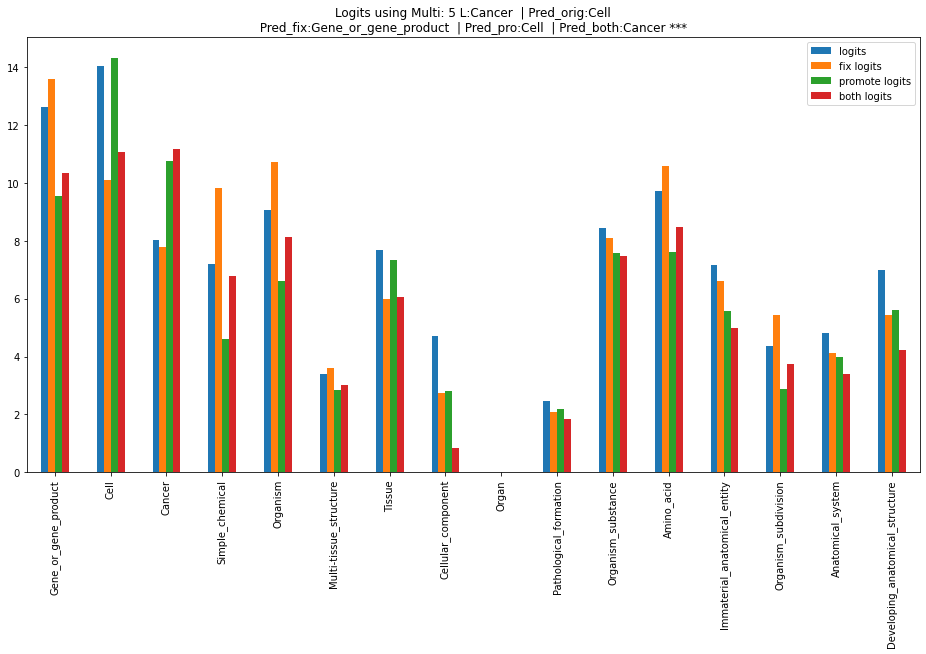

In [36]:
mult=5
out, fixed_out, promoted_out, both_out, mani_ped = test_example(pmodel, 77, combined_df, et_fix, et_promote, mult, device, quiet=False)

#multiplier 5 fixes this prediction !!!  

Testing  77 mention: SKOV-3 label: 2 # tokens: 395
True_label [2] Cancer
Pred: 1 Cell
Fixed Pred: 0 Gene_or_gene_product
Promoted Pred: 1 Cell
Both Pred: 2 Cancer

ENTITY TYPES PRE VS ET FIX VS ET PROMOTE VS BOTH with MULT 10
0 	 0.292 ovary                           0.292 ovary                           1.0 neoplasm                        1.0 neoplasm
1 	 0.2 cell_(biology)                  0.138 gene                            1.0 cancer                          1.0 cancer
2 	 0.138 gene                            0.09 human                           1.0 infectious causes of cancer     1.0 infectious causes of cancer
3 	 0.09 human                           0.078 neoplasm                        1.0 breast_cancer                   1.0 breast_cancer
4 	 0.078 neoplasm                        0.06 derivative_(chemistry)          1.0 pancreatic_cancer               1.0 pancreatic_cancer
5 	 0.06 derivative_(chemistry)          0.049 antigen                         1.0 cancer treatments   

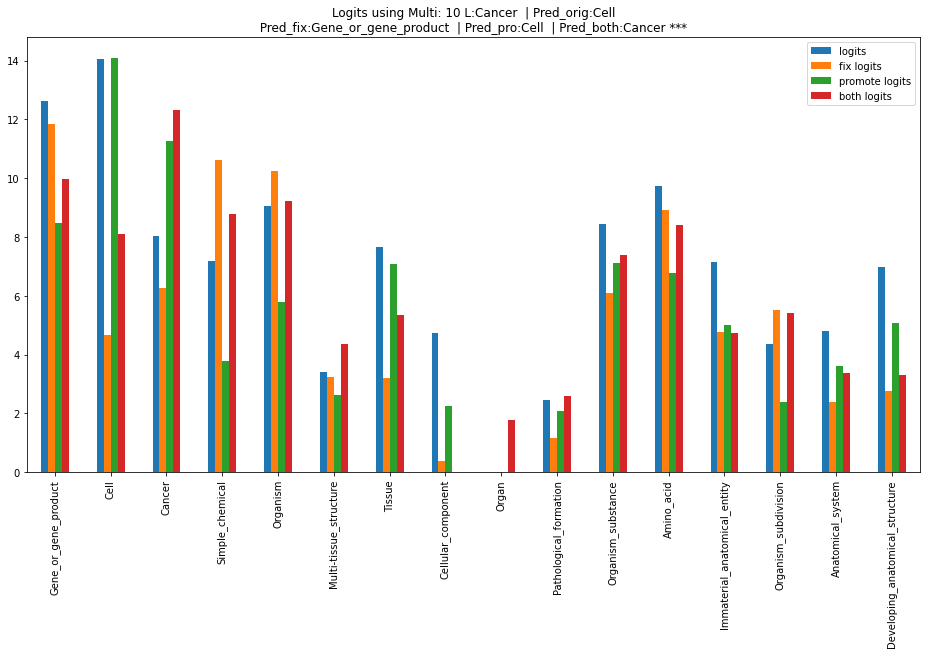

In [37]:
mult=10  # Multiplier 10 also fixes this prediction
out, fixed_out, promoted_out, both_out, mani_ped = test_example(pmodel, 77, combined_df, et_fix, et_promote, mult, device, False,"single_mult10fix.pdf")

Testing  77 mention: SKOV-3 label: 2 # tokens: 395
True_label [2] Cancer
Pred: 1 Cell
Fixed Pred: 3 Simple_chemical
Promoted Pred: 2 Cancer
Both Pred: 3 Simple_chemical

ENTITY TYPES PRE VS ET FIX VS ET PROMOTE VS BOTH with MULT 100
0 	 0.292 ovary                           0.292 ovary                           1.0 neoplasm                        1.0 neoplasm
1 	 0.2 cell_(biology)                  0.138 gene                            1.0 cancer                          1.0 cancer
2 	 0.138 gene                            0.09 human                           1.0 infectious causes of cancer     1.0 infectious causes of cancer
3 	 0.09 human                           0.078 neoplasm                        1.0 breast_cancer                   1.0 breast_cancer
4 	 0.078 neoplasm                        0.06 derivative_(chemistry)          1.0 pancreatic_cancer               1.0 pancreatic_cancer
5 	 0.06 derivative_(chemistry)          0.049 antigen                         1.0 cancer treatm

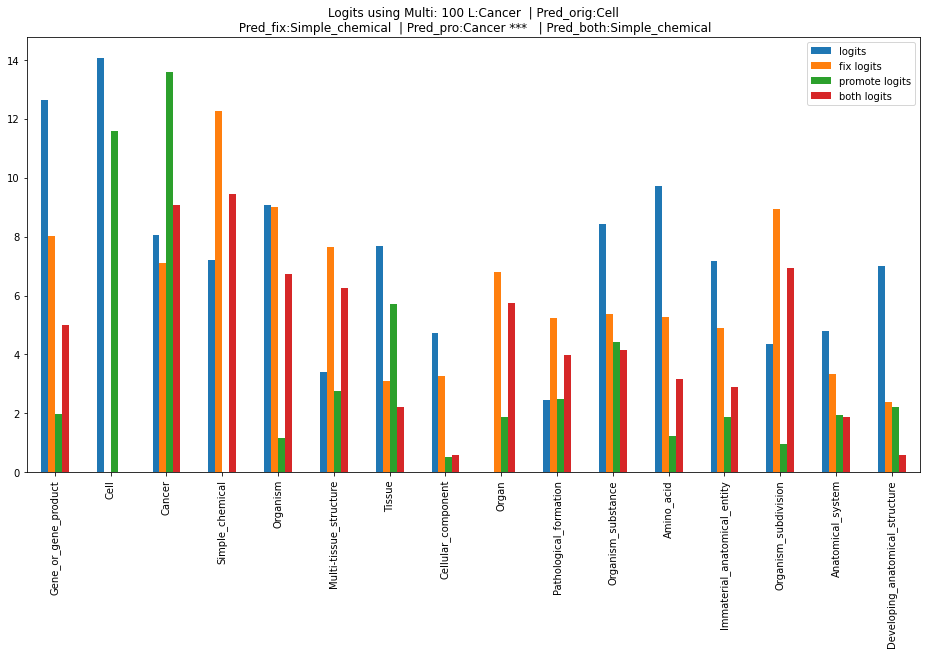

In [38]:
mult=100
out, fixed_out, promoted_out, both_out, mani_ped = test_example(pmodel, 77, combined_df, et_fix, et_promote, mult, device, quiet=False)

In [39]:
#insights from above:
#xx Cell is most likely to get misclassified as Cancer (40) and then Gene_or_gene_product (30) out of 1054
#Cancer is most likely to get misclassified as Cell (24) and then Organism_subdivision (10) out of 925
#Gene_or_gene_product is most likely to get misclassified as Organism (19) and Simple Chemical (15) out of 2520
#Simple Chemical is most likely to get misclassified as Gene_or_gene_product (68) out of 727
#Organism is most likely to get misclassified as Gene_or_gene_product (13) and then Cell (12)  out of 543
#Multitissue structure is most likely to get misclassifed as Tissue (20) and then Cancer (13) out of 303

x = combined_df['ffn_correct?']
print(sum([1 for v in x.values if v == True ]))  #base is 6363 / 6955 = 91.48

# USING ORACLE APPROACH
# promote / both
# with 41 or 31 correct from Cancer -> Cell
# with 34 or 34 correct from Gene -> Cell
# with 14 or 16 correct from Cell -> Cancer  
#       Organism_subdivision -> Cancer
#       Organism -> Gene_or_gene_product
#       Simple Chemical -> Gene_or_gene_product
#       Gene_or_gene_product -> Simple Chemical
#       Gene_or_gene_product -> Organism
#       Cell -> Organism
#       Tissue -> Multitissue structure
#       Cancer -> Multitissue structure

#thus far with promote, we get 6452 / 6955 = 92.76

6363


In [40]:
#fix when Cancer is predicted and it should have been Cell

def run_fix(ids,pred_label, true_label, et_fix, et_promote):
  mult = 10
  both_correct, promote_correct, fix_correct = 0, 0, 0
  both_corlist, promote_corlist, fix_corlist = [], [], []
  for ind in ids.index.values:
    out, fixed_out, promoted_out, both_out, mani_ped = test_example(pmodel, ind, combined_df, et_fix, et_promote, mult, device, quiet=True)
    if mani_ped[2] == true_label:
      both_correct +=1
      both_corlist.append(ind)
    if mani_ped[1] == true_label:
      promote_correct +=1
      promote_corlist.append(ind)
    if mani_ped[0] == true_label:
      fix_correct +=1 
      fix_corlist.append(ind)
    print("")   
  print("Found ",ids.shape[0], "Where ",pred_label," was predicted and ",true_label," was true label")
  print("Corrected ", both_correct," with Both approach")
  print("Corrected ", promote_correct," with Promote approach")
  print("Corrected ", fix_correct," with Fix approach")
  return [both_corlist, promote_corlist, fix_corlist]

pred_label = 'Cancer'
true_label = 'Cell'
ids = combined_df[(combined_df['ffn_pred_txt']==pred_label) & (combined_df['label_txt']==true_label)]
et_fix =  cancer_et_term_ids 
et_promote = cell_et_term_ids  #[3,145, 288, 370, 776, 1275] 
  
#run_fix(ids,pred_label, true_label, et_fix, et_promote)

#Found  41 Where  Cancer  was predicted and  Cell  was true label
#Corrected  31  with Both approach  
#Corrected  41  with Promote approach
#Corrected  0  with Fix approach


In [41]:
# When Gene_or_gene_product is predicted and it should have been Cell
pred_label = 'Gene_or_gene_product'
true_label = 'Cell'
ids = combined_df[(combined_df['ffn_pred_txt']==pred_label) & (combined_df['label_txt']==true_label)]
et_fix =  gene_et_term_ids 
et_promote = cell_et_term_ids 
  
#run_fix(ids,pred_label, true_label, et_fix, et_promote)
""""
Found  34 Where  Gene_or_gene_product  was predicted and  Cell  was true label
Corrected  34  with Both approach
Corrected  34  with Promote approach
Corrected  0  with Fix approach
"""

'"\nFound  34 Where  Gene_or_gene_product  was predicted and  Cell  was true label\nCorrected  34  with Both approach\nCorrected  34  with Promote approach\nCorrected  0  with Fix approach\n'

In [42]:
# NOW go through all examples that FFN predicted Cell when it should have been cancer and see how things get resolved
pred_label = 'Cell'
true_label = 'Cancer'
ids = combined_df[(combined_df['ffn_pred_txt']==pred_label) & (combined_df['label_txt']==true_label)]
et_fix = [3,145, 288, 370, 776, 1275]
et_promote = cancer_et_term_ids  
  
#run_fix(ids, pred_label, true_label, et_fix, et_promote)

"""
Found  16 Where  Cell  was predicted and  Cancer  was true label
Corrected  16  with Both approach
Corrected  14  with Promote approach
Corrected  4  with Fix approach
"""

'\nFound  16 Where  Cell  was predicted and  Cancer  was true label\nCorrected  16  with Both approach\nCorrected  14  with Promote approach\nCorrected  4  with Fix approach\n'

## A3 run automated entity manipulation

In [43]:
#1. get incorrect classifications and how
true_labels = combined_df['label_txt'].values
pred_labels = combined_df['ffn_pred_txt'].values
cm = confusion_matrix(true_labels, pred_labels, labels=id2label)
cm_df = pd.DataFrame(cm,index = id2label, columns = id2label)

#2. For each row (actual label), get the preds above 10 (ie significant number for 6955)
#2a. get set of misclassifcations
thresh = 0  #SET THRESHOLD FOR HOW MANY ERRORS NEED TO APPEAR TO FOR A PATTERN BEFORE YOU FIX IT  ( 9 or 0)

set_to_fix = []
for cur_c in id2label:
  #print("trying ", cur_c)
  loc_set = []
  cur = cm_df.loc[cur_c]  
  for c in id2label:
    #print("---",c,cur[c])
    if c != cur_c and cur[c] > thresh:  
      #print("------Found. Actual:", cur_c, "but Predicted:",c, "-->",cur[c])
      loc_set.append([cur_c,c, cur[c]])
      set_to_fix.append([cur_c,c,cur[c]])
  if len(loc_set) > 0:
    print("For ",cur_c, "found set",loc_set)
  
print("Found ", len(set_to_fix), "sets to fix")   #19 when thresh is 9, and 104 when thresh is 0

For  Gene_or_gene_product found set [['Gene_or_gene_product', 'Cell', 9], ['Gene_or_gene_product', 'Cancer', 4], ['Gene_or_gene_product', 'Simple_chemical', 17], ['Gene_or_gene_product', 'Organism', 15], ['Gene_or_gene_product', 'Multi-tissue_structure', 3], ['Gene_or_gene_product', 'Tissue', 1], ['Gene_or_gene_product', 'Cellular_component', 3]]
For  Cell found set [['Cell', 'Gene_or_gene_product', 34], ['Cell', 'Cancer', 41], ['Cell', 'Simple_chemical', 14], ['Cell', 'Organism', 2], ['Cell', 'Multi-tissue_structure', 1], ['Cell', 'Tissue', 10], ['Cell', 'Cellular_component', 10], ['Cell', 'Organ', 6], ['Cell', 'Organism_substance', 4]]
For  Cancer found set [['Cancer', 'Gene_or_gene_product', 3], ['Cancer', 'Cell', 16], ['Cancer', 'Organism', 3], ['Cancer', 'Multi-tissue_structure', 4], ['Cancer', 'Tissue', 5], ['Cancer', 'Organ', 4], ['Cancer', 'Pathological_formation', 1], ['Cancer', 'Organism_substance', 1], ['Cancer', 'Immaterial_anatomical_entity', 4], ['Cancer', 'Organism_subdi

In [44]:
#existing term sets
term_sets = {'Cell' : cell_et_term_ids,
             'Cellular_component' : cell_et_term_ids,
             'Cancer': cancer_et_term_ids,
             'Gene_or_gene_product': gene_et_term_ids,
             'Simple_chemical': chem_et_term_ids,
             'Organism': organ_et_term_ids,
             'Organism_substance': organ_et_term_ids,
             'Organism_subdivision': organ_et_term_ids,
             'Organ': organ_et_term_ids,
             'Tissue': tissue_et_term_ids,
             'Multi-tissue_structure': tissue_et_term_ids,
             'Amino_acid': amino_et_term_ids,
             'Pathological_formation': path_et_term_ids,
             'Immaterial_anatomical_entity': antom_et_term_ids,
             'Developing_anatomical_structure': antom_et_term_ids,
             'Anatomical_system': antom_et_term_ids,
             }

#3. finally run all combinations and save 

t0 = time.time()
total_ids = 0
result_sets = []
for v in set_to_fix:  
  pred_label = v[1]
  true_label = v[0]
  print("\n=============================================================")
  print("Testing expected ", true_label, "but predicted ",pred_label)
  print("=============================================================")
  ids = combined_df[(combined_df['ffn_pred_txt']==pred_label) & (combined_df['label_txt']==true_label)]
  if pred_label in term_sets and true_label in term_sets:
    et_fix =  term_sets[pred_label]
    et_promote = term_sets[true_label]  
    both_corlist, promote_corlist, fix_corlist = run_fix(ids,pred_label, true_label, et_fix, et_promote)
    result_sets.append([v,both_corlist, promote_corlist, fix_corlist, ids])
    total_ids += ids.shape[0]
  else:
    print("!!!! SKIPPED",v)
    import sys
    sys.exit()
  

print("Found: ", total_ids, "examples")  
print("Done. Elapsed:", time.time() - t0)

#Found:  344 examples for thresh 9, takes 62 seconds  (  19 groupings)
#Found:  592 examples for thresh 0, takes 103 seconds ( 104 groupings)


Testing expected  Gene_or_gene_product but predicted  Cell
Testing  601 mention: vesicle label: 0 # tokens: 314
index:601|Multi: 10 L:Gene_or_gene_product  | Pred_orig:Cell
 Pred_fix:Simple_chemical  | Pred_pro:Cell  | Pred_both:Simple_chemical

Testing  6429 mention: G45 label: 0 # tokens: 244
index:6429|Multi: 10 L:Gene_or_gene_product  | Pred_orig:Cell
 Pred_fix:Simple_chemical  | Pred_pro:Cell  | Pred_both:Simple_chemical

Testing  6437 mention: G45 label: 0 # tokens: 244
index:6437|Multi: 10 L:Gene_or_gene_product  | Pred_orig:Cell
 Pred_fix:Simple_chemical  | Pred_pro:Cell  | Pred_both:Simple_chemical

Testing  6440 mention: G45 label: 0 # tokens: 244
index:6440|Multi: 10 L:Gene_or_gene_product  | Pred_orig:Cell
 Pred_fix:Simple_chemical  | Pred_pro:Cell  | Pred_both:Simple_chemical

Testing  6442 mention: G45 label: 0 # tokens: 244
index:6442|Multi: 10 L:Gene_or_gene_product  | Pred_orig:Cell
 Pred_fix:Simple_chemical  | Pred_pro:Cell  | Pred_both:Simple_chemical

Testing  6447

## A4 construct tables for paper

In [45]:
from IPython.display import display, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("_","\\n").replace("\\n","<br>") ) )

cancer_search_terms = ['cancer','neoplasm'] 
cell_search_term = ['cell']
gene_search_terms = [[' gene', 'gene ', ' genes', 'genes '], ["generation", "general"]]
chem_search_terms = [' chemical', 'chemical ']
organ_search_terms = [[' organ', 'organ ', 'organism'], ["organization"]]
tissue_search_terms = [' tissue', 'tissue ']
amino_search_terms = [' amino', 'amino ', 'amino acid']
path_search_terms = ['pathological']
antom_search_terms = ['anatomical ', ' anatomical', 'anatomical']

term_set_rules = {'Cell' : [cell_search_term , len(cell_et_term_ids)],
             'Cellular_component' : [cell_search_term , len(cell_et_term_ids)],
             'Cancer': [cancer_search_terms, len(cancer_et_term_ids)],
             'Gene_or_gene_product': [ gene_search_terms, len(gene_et_term_ids)],
             'Simple_chemical': [chem_search_terms, len(chem_et_term_ids)],
             'Organism': [organ_search_terms, len(organ_et_term_ids)],
             'Organism_substance': [organ_search_terms, len(organ_et_term_ids)],
             'Organism_subdivision': [organ_search_terms, len(organ_et_term_ids)],
             'Organ': [organ_search_terms, len(organ_et_term_ids)],
             'Tissue': [tissue_search_terms, len(tissue_et_term_ids)],
             'Multi-tissue_structure': [tissue_search_terms, len(tissue_et_term_ids)],
             'Amino_acid': [amino_search_terms, len(amino_et_term_ids)],
             'Pathological_formation': [path_search_terms, len(path_et_term_ids)],
             'Immaterial_anatomical_entity': [antom_search_terms, len(antom_et_term_ids)],
             'Developing_anatomical_structure': [antom_search_terms, len(antom_et_term_ids)],
             'Anatomical_system': [antom_search_terms, len(antom_et_term_ids)],
             }

#cancer_et_term_labels, cell_et_term_labels, gene_et_term_labels, chem_et_term_labels, 
#organ_et_term_labels, tissue_et_term_labels, amino_et_term_labels, path_et_term_labels

tsr_res = []
for k in term_set_rules:
  v1 = term_set_rules[k][0]
  if type(v1[0]) == list:
    v1 = str(v1[0]) + "\nnot in " + str(v1[1])

  tsr_res.append([k.replace("_"," "),v1,term_set_rules[k][1]] )

tsr_df = pd.DataFrame(tsr_res, columns=['Class','Term Rules Inclusion/Exclusion','Terms in Set'])
pretty_print(tsr_df)

,Class,Term Rules Inclusion/Exclusion,Terms in Set
0,Cell,[cell],357
1,Cellular component,[cell],357
2,Cancer,"[cancer, neoplasm]",155
3,Gene or gene product,"[' gene', 'gene ', ' genes', 'genes ']not in ['generation', 'general']",434
4,Simple chemical,"[ chemical, chemical ]",80
5,Organism,"[' organ', 'organ ', 'organism']not in ['organization']",172
6,Organism substance,"[' organ', 'organ ', 'organism']not in ['organization']",172
7,Organism subdivision,"[' organ', 'organ ', 'organism']not in ['organization']",172
8,Organ,"[' organ', 'organ ', 'organism']not in ['organization']",172
9,Tissue,"[ tissue, tissue ]",15


In [46]:
#print(tsr_df.to_latex())

In [47]:
# ERRROR PATTERN RESULTS

rez = []
all_ids, all_ids_fixed = [],[]
sum_ids, sum_ids2 = 0, 0
for v in result_sets:
  best = len(v[1]) if len(v[1]) > len(v[2]) else len(v[2])
  if len(v[3]) > best:
    best = len(v[3])
  set_all = list(set(v[1] + v[2] + v[3]))
  rez.append([v[0][0],v[0][1],v[0][2], len(v[1]), len(v[2]),len(v[3]), 
              len(set_all), best, v[0][2]-best, v[4].index.values, set_all])
  sum_ids += v[0][2]
  sum_ids2 += len(v[4])  
  for ind in v[4].index.values:
    all_ids.append(ind)
  for ind in set_all:
    all_ids_fixed.append(ind)    
  

print(sum_ids, sum_ids2, len(all_ids))  
#344 344 344   for thresh 9
#592 592 592   for thresh 0
rdf = pd.DataFrame(rez, columns=['actual','pred','errors_found','both_fixed',
                                 'promote_fixed','fix_fixed','unison_len','best','diff',"ids","unison_ids"])
rdf = rdf.append(rdf.sum(numeric_only=True), ignore_index=True)

to_show_df = rdf[rdf['errors_found'] > 3].sort_values(by=['errors_found'], ascending=False)
to_show_df['best_pct'] = [round(to_show_df.iloc[i]['best'] / to_show_df.iloc[i]['errors_found'],4) for i in range(to_show_df.shape[0])]
pretty_print(to_show_df[['actual','pred','errors_found','both_fixed','promote_fixed','fix_fixed','best','best_pct']])

print(to_show_df[['actual','pred','errors_found','both_fixed','promote_fixed','fix_fixed','best','best_pct']].to_latex(index_names=False))

592 592 592


,actual,pred,errorsfound,bothfixed,promotefixed,fixfixed,best,bestpct
104,NaN,NaN,592.0,292.0,296.0,169.0,361.0,0.6098
26,Simplechemical,Geneorgeneproduct,65.0,64.0,48.0,59.0,64.0,0.9846
8,Cell,Cancer,41.0,31.0,41.0,0.0,41.0,1.0000
7,Cell,Geneorgeneproduct,34.0,34.0,34.0,0.0,34.0,1.0000
42,Multi-tissuestructure,Tissue,22.0,0.0,0.0,7.0,7.0,0.3182
2,Geneorgeneproduct,Simplechemical,17.0,3.0,3.0,10.0,10.0,0.5882
68,Organ,Tissue,16.0,12.0,10.0,12.0,12.0,0.7500
17,Cancer,Cell,16.0,0.0,14.0,0.0,14.0,0.8750
3,Geneorgeneproduct,Organism,15.0,6.0,0.0,15.0,15.0,1.0000
9,Cell,Simplechemical,14.0,14.0,14.0,4.0,14.0,1.0000


\begin{tabular}{lllrrrrrr}
\toprule
{} &                  actual &                          pred &  errors\_found &  both\_fixed &  promote\_fixed &  fix\_fixed &   best &  best\_pct \\
\midrule
104 &                     NaN &                           NaN &         592.0 &       292.0 &          296.0 &      169.0 &  361.0 &    0.6098 \\
26  &         Simple\_chemical &          Gene\_or\_gene\_product &          65.0 &        64.0 &           48.0 &       59.0 &   64.0 &    0.9846 \\
8   &                    Cell &                        Cancer &          41.0 &        31.0 &           41.0 &        0.0 &   41.0 &    1.0000 \\
7   &                    Cell &          Gene\_or\_gene\_product &          34.0 &        34.0 &           34.0 &        0.0 &   34.0 &    1.0000 \\
42  &  Multi-tissue\_structure &                        Tissue &          22.0 &         0.0 &            0.0 &        7.0 &    7.0 &    0.3182 \\
2   &    Gene\_or\_gene\_product &               Simple\_chemical &

In [48]:
# 1. What is the overlap between these 344 and those from E2E model?
# 2. What happens if we tried to fix all errors and not just those with 10 or more errors ?  !!!
all_ffn_error_ids = sorted(all_ids)  
all_ffn_error_ids_fixed = sorted(all_ids_fixed)  
all_ffn_err_df = combined_df[combined_df.index.isin(all_ffn_error_ids)]   #344
all_ffn_err_fixed_df = combined_df[combined_df.index.isin(all_ffn_error_ids_fixed)]   #344

print(all_ffn_err_df.shape, all_ffn_err_df['e2e_correct?'].value_counts())              #344, (cor: 227, incor: 117)  for thresh 9
print(all_ffn_err_fixed_df.shape, all_ffn_err_fixed_df['e2e_correct?'].value_counts())  #258, (cor: 199, incor:59)    for thresh 9

#all exs 344, (cor: 227, incor:117)    for thresh 9
#fixed   258, (cor: 199, incor: 59)    for thresh 9

#all exs 592, (cor: 363, incor:229)    for thresh 0
#fixed   361, (cor: 269, incor: 92)    for thresh 0

# so just fix all 


(592, 16) True     363
False    229
Name: e2e_correct?, dtype: int64
(361, 16) True     269
False     92
Name: e2e_correct?, dtype: int64


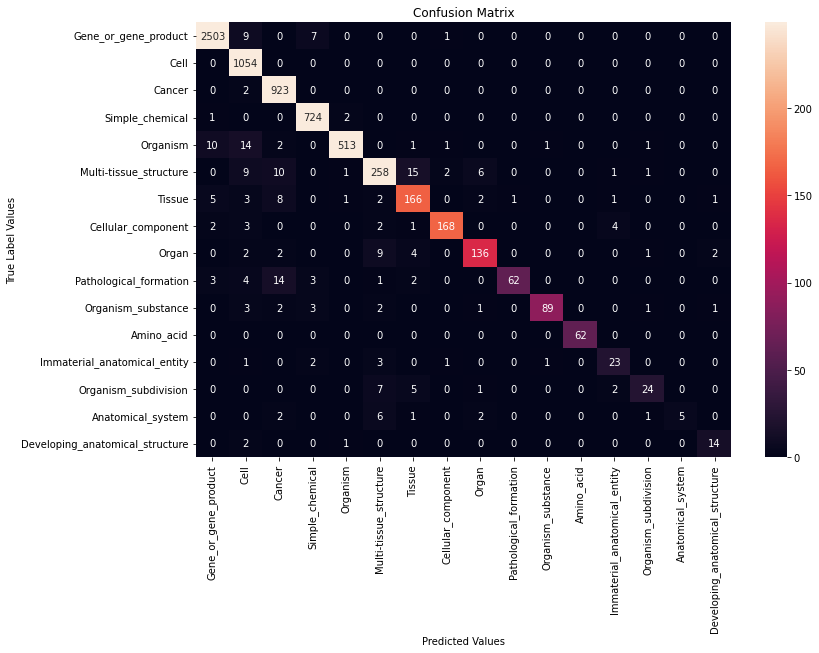

In [49]:
# How does the above look like when we don't include IDS which FFN was able to fix
combined_df_fixed = combined_df.copy()
for i in range(combined_df_fixed.shape[0]):
  if i in all_ids_fixed:
    cur = combined_df_fixed.loc[i]
    combined_df_fixed.at[i,'ffn_pred'] = cur.label
    combined_df_fixed.at[i,'ffn_pred_txt'] = cur.label_txt
    combined_df_fixed.at[i,'ffn_correct?'] = True

#sum([1 for v in combined_df_fixed['ffn_correct?'].values if v == True])  #6724/6955  == 96.68

#ff = combined_df_fixed[(combined_df_fixed['e2e_correct?'] == True)& (combined_df_fixed['ffn_correct?'] == False)]
#E2E:      6955 total of which  6648 correct and  307 wrong
#FFNfixed: 6955 total of which  6724 correct and  231 wrong

#print(ff.shape)  #(94 questions that E2E gets right that FFN doesn't  ... which is substantially less than 363 )

#cm_df = show_confusion(ff['e2e_pred_txt'].values, ff['ffn_pred_txt'].values)
cm_df = show_confusion(combined_df_fixed['label_txt'].values, combined_df_fixed['ffn_pred_txt'].values,"confusion_mat_test_ffn_postfix_v2.pdf")

In [50]:
#cm_df = cm_df.append(cm_df.sum(numeric_only=True), ignore_index=True)
#cm_df.tail(1)  #sums

#so main differences are (over 94 where E2E is right at FFN isn't)
#Cell predicted incorrectly 40 more times with FFN
#Multi-tissue "" 12 more times
#Cancer "" 11 more times

## c1 do inference on training, get weight sums/threshold

In [51]:
#C1
#1. get training data
#2. using trained_model do inference and get weight sums above .01 for training data 
#   and determine the threshhold to split the correct vs incorrect predictions.
#3. use that threshhold on test data and determine how well it identifies correct / incorrect predictions
#   If it does a good job thats away to gauge confidence for flagging possibly incorrect predictions!!

train_ids = glob.glob('./elc_data/BioNLP-ST_2013_CG_training_data/PMID-*.a1')       
dev_ids = glob.glob('./elc_data/BioNLP-ST_2013_CG_development_data/PMID-*.a1')  
pmids = train_ids + dev_ids     
train_data = get_mentions(pmids)


In [52]:
#do inference on training data (load data ) Elapsed. 70.9554283618927  (do inference)  gives 96.8 acc)
model_id = '0612_train_'
train_prediction_dataloader, test_texts = get_test_data(model, pmids, train_data, label_map)
my_train_data = do_test(pmodel, train_prediction_dataloader, model_id, device, label_map )

Elapsed. 33.26301956176758
Evaling  0612_train_
(14569, 16) (14569,) (14569,)
Done Testing. Elapsed: 326.9966790676117
Test acc: 0.9680142768892854
Saving out results to out/ with prefix  0612_train_


In [53]:
#do weight sums
def get_train_df(ffn_preds, true_preds):
  res = []
  for i in range(true_preds.shape[0]):    
    try:      
      ffn_pred = np.argmax(ffn_preds[i])
      true_pred = true_preds[i]
      res.append([true_pred, 
                ffn_pred, ffn_pred == true_pred,                
                [ round(v,3) for v in ffn_preds[i]]])
    except Exception as e:
      print("Error at i",i,e)
        
  return pd.DataFrame(res, columns=["label","ffn_pred","ffn_correct?","ffn_preds"])

cur_train_ffn_ets = np.load("out/0612_train__test_single_entity_types.npy")
cur_train_ffn_preds = np.load("out/0612_train__test_full_predictions.npy")
cur_train_true_preds = np.load("out/0612_train__test_true_labels.npy")
curt_df = get_train_df(cur_train_ffn_preds, cur_train_true_preds)  

ets_train_sig = loc_sigmoid(cur_train_ffn_ets)
train_probs = get_topk_types_v2(ets_train_sig) 

In [54]:
to_add = []
for i, pmid in enumerate(pmids):
  tmp_pmid = "PMID" + pmid.split("PMID")[1]
  pmid = tmp_pmid.split(".")[0]
  exs = train_data[pmid]
  title = exs[0]
  abstract = exs[1]
  mentions = exs[2]
  for m in mentions:
    mention = m[2]
    label, start, end = m[1].split(" ") 
    to_add.append([pmid,mention,label,start,end,abstract])

to_add_df = pd.DataFrame(to_add, columns=["pmid","mention","label_txt","start","end","abstract"])
combinet_df = pd.concat([curt_df, to_add_df], axis = 1)
combinet_df.head(2)

,label,ffn_pred,ffn_correct?,ffn_preds,pmid,mention,label_txt,start,end,abstract
0,4,4,True,"[-2.277, -0.979, -3.891, -3.418, 7.898, -4.862...",PMID-17608264,human,Organism,36,41,BACKGROUND: Inhibition of angiogenesis reverse...
1,6,6,True,"[-3.727, -3.003, -3.809, -9.079, -8.992, -1.37...",PMID-17608264,fat tissue,Tissue,42,52,BACKGROUND: Inhibition of angiogenesis reverse...


In [55]:
train_ffn_cor_indices = combinet_df[combinet_df['ffn_correct?'] == True].index.values
train_ffn_incor_indices = combinet_df[combinet_df['ffn_correct?'] == False].index.values

train_cor_types = []
for ind in train_ffn_cor_indices:
  train_cor_types.append(show_types(ind, combinet_df, train_probs[ind], threshhold=.01, printout=False))

train_incor_types = []
for ind in train_ffn_incor_indices:
  train_incor_types.append(show_types(ind, combinet_df, train_probs[ind], threshhold=.01, printout=False))

print(len(train_cor_types), len(train_incor_types), combinet_df.shape[0])
# 14103 correct,  466 incorrect, out of 14569   --> 96.8 accuracy on train when val converged

14103 466 14569


## c3. Global Explanations via Class Prototypes and Negative Error Prototypes

In [56]:
# COMBINET IS RESULTS ON TRAINING DATA
all_train_types = []
for ind in combinet_df.index.values: 
  all_train_types.append(show_types(ind, combinet_df, train_probs[ind], threshhold=.01, printout=False))

all_ffn_num_types = [len(v) for v in all_train_types]
all_ffn_sums = [sum([v2[0] for v2 in v]) for v in all_train_types]
combinet_df['ffn_types_above_pt01'] = all_train_types
combinet_df['ffn_num_types_above_pt01'] = all_ffn_num_types
combinet_df['ffn_sum_weights_above_pt01'] = all_ffn_sums

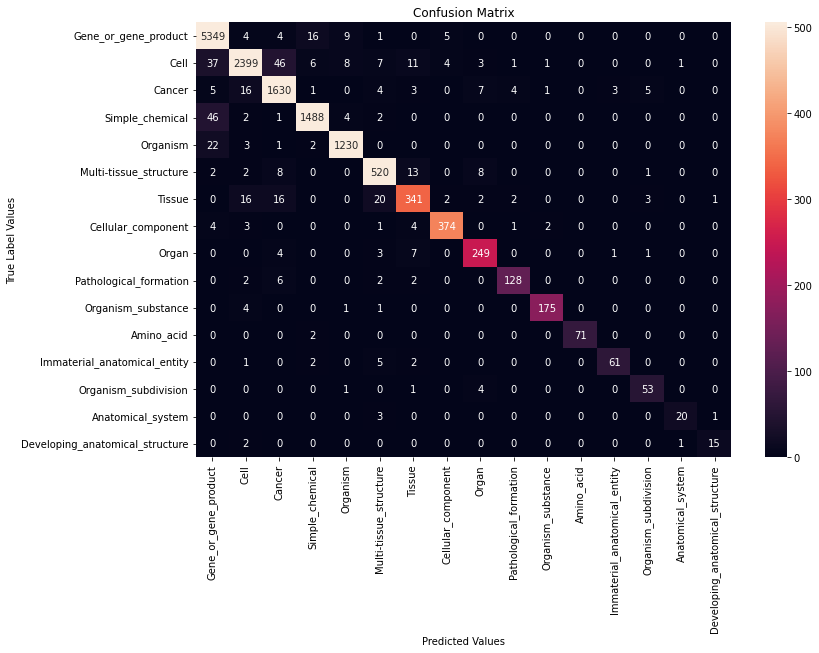

In [57]:
combinet_df['ffn_pred_txt'] = [id2label[v] for v in combinet_df['ffn_pred'].values]
train_cm_df = show_confusion(combinet_df['label_txt'].values, combinet_df['ffn_pred_txt'].values, "train_confusion_mat.pdf")
#train confusion ( save)

In [58]:
# OVER TRAINING DATA

#automate getting highest non-diagnol numbers and entity types/stats per each 
cols = train_cm_df.columns
err_pats = []
non_err_pats = []
for r in cols:
  for c in cols:
    cur = train_cm_df[train_cm_df.index == r][c]
    cur_df = combinet_df[(combinet_df['label_txt'] == r)&(combinet_df['ffn_pred_txt']==c)]
    if r != c:            
      err_pats.append([r,c,cur.values[0], cur_df.index.values, list(cur_df['ffn_types_above_pt01'].values) ])
    else:
      non_err_pats.append([r,c,cur.values[0], cur_df.index.values, list(cur_df['ffn_types_above_pt01'].values) ])


#now sort by raw number and then get ets for each
err_pats.sort(key=lambda x: x[2], reverse=True )
non_err_pats.sort(key=lambda x: x[2], reverse=True )
print(len(err_pats), err_pats[0][0:3],len(err_pats[0][3]), err_pats[4])   #240 ['Cell', 'Cancer', 46], 46


err_pats_dict = {c:{} for c in cols}
non_err_pats_dict = {c:{} for c in cols}
eps = .00001
for c in cols:
  for r in cols:
    cur = train_cm_df[train_cm_df.index == r][c]
    cur_df = combinet_df[(combinet_df['label_txt'] == r)&(combinet_df['ffn_pred_txt']==c)]
    cur_inds = cur_df.index.values
    cur_dict = {}
    for ind,tset in enumerate(list(cur_df['ffn_types_above_pt01'].values)):
      cur_ind = cur_inds[ind]      
      for t in tset:
        if t[1] not in cur_dict:
          cur_dict[t[1]] = {'inds': [cur_ind], 'weights': [t[0]]}
        else:
          cur_dict[t[1]]['inds'].append(cur_ind)
          cur_dict[t[1]]['weights'].append(t[0])

    lens = [len(cur_dict[v]['inds']) for v in cur_dict]    
    if len(lens) > 0:
      max_len = np.max(lens)
    else:
      max_len = 1
    max_log_len = np.log(max_len)  
    term_counts, term_weight_sums, term_weight_avgs = [], [], []
    for t in cur_dict:
      cur_dict[t]['raw_count'] = len(cur_dict[t]['inds'])
      cur_dict[t]['weight_sum'] = sum(cur_dict[t]['weights'])

      #so this average is, when this entity types appears, it has this value on average
      #however for rare types that appear once and have high weights its not really reflective
      #cur_dict[t]['avg_sum'] = round(cur_dict[t]['weight_sum']/cur_dict[t]['raw_count'],4)

      #future: MAYBE we needed a weight average.. maybe  log(raw count +eps) + avg_sum ?  
      log_len = np.log(len(cur_dict[t]['inds']) + eps)          
      cur_dict[t]['avg_sum'] = round(cur_dict[t]['weight_sum']/cur_dict[t]['raw_count'] + (log_len/max_log_len),4)

      term_counts.append([t,cur_dict[t]['raw_count']])
      term_weight_sums.append([t,cur_dict[t]['weight_sum']])
      term_weight_avgs.append([t,cur_dict[t]['avg_sum']])
    
    term_counts.sort(key=lambda x: x[1], reverse=True )
    term_weight_sums.sort(key=lambda x: x[1], reverse=True )
    term_weight_avgs.sort(key=lambda x: x[1], reverse=True )
  
    out = {'inds': cur_inds, 'terms':cur_dict, 'term_counts': term_counts,
           'term_weight_sums': term_weight_sums, 'term_weight_avgs': term_weight_avgs}
    if r != c:
      err_pats_dict[c][r] = out
    else:
      non_err_pats_dict[c] = out

240 ['Cell', 'Cancer', 46] 46 ['Tissue', 'Multi-tissue_structure', 20, array([  254,   274,  1020,  1024,  2413,  3034,  5688,  6688,  6808,
        6811,  6820,  6890,  7125,  7705,  8238,  9519, 12486, 12995,
       13246, 13397]), [[(0.8058585, 'skin'), (0.39490163, 'blood_vessel'), (0.18745299, 'ear'), (0.09950196, 'nephron'), (0.07874603, 'disease'), (0.076792024, 'blood'), (0.058044765, 'psychosis'), (0.03148006, 'tongue'), (0.029299797, 'human_gastrointestinal_tract'), (0.027579058, 'human_body'), (0.02659173, 'soft tissue'), (0.025896156, 'organ_(anatomy)'), (0.02219971, 'auditory system'), (0.02107402, 'nitrous_oxide'), (0.020844355, 'angiology'), (0.020770557, 'plastic surgery'), (0.019929277, 'neurology'), (0.018906089, 'kidney'), (0.018359417, 'nervous_system'), (0.018049203, 'neoplasm'), (0.017779998, 'dermatology'), (0.015029135, 'mediterranean'), (0.014466346, 'sunlight'), (0.013779331, 'synthesizer'), (0.012890381, 'surgery'), (0.012243709, 'time')], [(0.99999964, 'soft

In [59]:
# automate getting highest non-diagnol numbers and entity types/stats per each
pd.set_option('display.width', 1000)

cur = 0
for cur_pat in err_pats:  
  true_label = cur_pat[0]
  pred_label = cur_pat[1]    
  cur_non_err_pat = non_err_pats_dict[true_label]
  cur_err_pat = err_pats_dict[pred_label][true_label]
  pred_non_err_pat = non_err_pats_dict[pred_label]

  err_inds = cur_err_pat['inds']
  err_terms = cur_err_pat['terms']
  if len(err_inds) != 0 and true_label == 'Gene_or_gene_product':
    print("\n=============================================================================================")
    print("Label:",true_label,"-- Pred:",pred_label)
    print("--  Incorrect:", "# Exs:", len(err_inds),"# Terms:", len(err_terms))    
    print("-- vs Correct:", "# Exs:", len(cur_non_err_pat['inds']), "# Terms:", len(cur_non_err_pat['terms']))
    print("\n --Top terms by Raw Count (Errors/Correct) for True:",true_label,"/Pred(here):",pred_label,"and Pred(class)")
    ce = cur_err_pat
    cn = cur_non_err_pat
    pt = pred_non_err_pat
    rezt = []
    for i in range(10):    
      if len(ce['term_counts']) > i and len(cn['term_counts']) > i:        
        rezt.append([ ce['term_counts'][i] ,cn['term_counts'][i], pt['term_counts'][i]])
    reztf_df = pd.DataFrame(rezt,columns=["Pred(here)"+pred_label[0:10], "True class_"+true_label[0:10], "Pred(class)"])
    print(reztf_df)
      
    print("\n--Top terms By Raw Weight Sums (Errors/Correct) for True:",true_label,"-- Pred:",pred_label)
    rezt = []
    for i in range(10):
      if len(ce['term_counts']) > i and len(cn['term_counts']) > i: 
        cew = ce['term_weight_sums'][i] 
        cnw = cn['term_weight_sums'][i]        
        cpw = pt['term_weight_sums'][i]
        rezt.append([ [cew[0],round(cew[1],2)] ,[cnw[0],round(cnw[1],2)], [cpw[0],round(cpw[1],2)]])
    reztf_df = pd.DataFrame(rezt,columns=["Pred(here)"+pred_label[0:10], "True class_"+true_label[0:10], "Pred(class)"])
    print(reztf_df)

    """
    print("\n--Top terms By AVG Weight Sums (Errors/Correct) for True:",true_label,"-- Pred:",pred_label)
    rezt = []
    for i in range(10):
      if len(ce['term_counts']) > i and len(cn['term_counts']) > i:        
        #print(ce['term_weight_avgs'][i],"\t", cn['term_weight_avgs'][i])    
        rezt.append([ ce['term_weight_avgs'][i] ,cn['term_weight_avgs'][i], pt['term_weight_avgs'][i]])
    reztf_df = pd.DataFrame(rezt,columns=["Pred(here)"+pred_label[0:10], "True class_"+true_label[0:10], "Pred(class)"])
    print(reztf_df)
    """
  cur += 1



# NEGATIVE PROTOTYPES FOR Gene class 
# the main thing is how to differentiate between Pred(here) and Pred(class)  are there some giveaways that you are about to make an error?


Label: Gene_or_gene_product -- Pred: Simple_chemical
--  Incorrect: # Exs: 16 # Terms: 359
-- vs Correct: # Exs: 5349 # Terms: 3907

 --Top terms by Raw Count (Errors/Correct) for True: Gene_or_gene_product /Pred(here): Simple_chemical and Pred(class)
           Pred(here)Simple_che       True class_Gene_or_ge                                        Pred(class)
0              [ingredient, 14]             [protein, 4455]                                 [ingredient, 1189]
1                    [acid, 10]          [ingredient, 4311]                                        [acid, 428]
2                  [protein, 8]               [human, 4135]                           [chemical_compound, 381]
3        [chemical_compound, 8]                [gene, 3976]                                         [rtt, 365]
4                    [human, 8]              [allele, 2760]  [world health organization essential medicines...
5                     [gene, 7]      [cell_(biology), 2102]                      

In [60]:
#NOTE INTERESTING ANALYSIS OF LOOKING AT TYPES MOST ASSOCIATED WITH EACH CLASS As Global Explainability

for cur_pat in non_err_pats:  
  true_label = cur_pat[0]
  total = combinet_df[combinet_df['label_txt'] == true_label].shape[0]
  cur_non_err_pat = non_err_pats_dict[true_label]
  
  print("\n=============================================================================================")
  l = len(cur_non_err_pat['inds'])
  print("\nClass:",true_label, "# Train Docs Correctly Predicted:", l , "out of ", total, "(",round(l/total,4),")")
  print("# Unique Terms:", len(cur_non_err_pat['terms']))
  #print("--Top terms by Raw Count / Raw Weight Sums / AVG Weight Sums")
  cn = cur_non_err_pat
  rezt = []
  n = 20 if len(cn['term_counts']) > 20 else len(cn['term_counts'])
  for i in range(n):          
    v = cn['term_weight_sums'][i]
    rezt.append([ cn['term_counts'][i], [v[0], round(v[1],2) ]])#), cn['term_weight_avgs'][i]])
  reztf_df = pd.DataFrame(rezt,columns=["raw counts","raw weight sums"])#,"weight sum avg"])
  print(reztf_df)

#NOTE AVG WEIGHT is ARTIFICIAL IN THAT SUPER RARE ONES WHICH OCCURED MAYBE ONCE COULD HAVE WEIGHT OF 1!






Class: Gene_or_gene_product # Train Docs Correctly Predicted: 5349 out of  5388 ( 0.9928 )
# Unique Terms: 3907
                         raw counts                               raw weight sums
0                   [protein, 4455]                             [protein, 3107.8]
1                [ingredient, 4311]                         [ingredient, 2304.97]
2                     [human, 4135]                              [human, 2264.92]
3                      [gene, 3976]                               [gene, 2107.83]
4                    [allele, 2760]                        [coagulation, 1118.03]
5            [cell_(biology), 2102]                     [cell_(biology), 1092.58]
6               [coagulation, 1734]                         [cell_growth, 972.54]
7                    [family, 1733]                         [endothelium, 820.04]
8                 [wild_type, 1633]                  [homology_(biology), 745.51]
9        [homology_(biology), 1620]                            [on

In [61]:
#get all positive cases for each class
all_positive_class_train_types = {c:[] for c in id2label}
for c in id2label:
  cur_df = combinet_df[(combinet_df['ffn_pred_txt'] == c)&(combinet_df['ffn_correct?']==True)]
  for ind in cur_df.index.values: 
    #all_positive_class_train_types[c].append(show_types(ind, combinet_df, train_probs[ind], threshhold=0, printout=False))
    all_positive_class_train_types[c].append(ets_train_sig[ind])

In [62]:
#do same for most pertinent criticisms
all_negative_example_class_train_types = []
for cur_pat in err_pats:  
  true_label = cur_pat[0]
  pred_label = cur_pat[1]    
  cur_err_pat = err_pats_dict[pred_label][true_label]
  err_inds = cur_err_pat['inds']  
  if len(err_inds) > 9:
    all_ind_types = []
    cur_df = combinet_df[(combinet_df['ffn_pred_txt'] == pred_label)&(combinet_df['label_txt']==true_label)]
    for ind in cur_df.index.values: 
      #all_ind_types.append(show_types(ind, combinet_df, train_probs[ind], threshhold=0, printout=False))
      all_ind_types.append(ets_train_sig[ind])
    all_negative_example_class_train_types.append([true_label,pred_label,all_ind_types])

In [65]:
from IPython.display import display, HTML
def pretty_print(df):
    return display( HTML( df.to_html().replace("_","\\n").replace("\\n","<br>") ) )

#print(len(all_positive_class_train_types))          #16 positive and 
#print(len(all_negative_example_class_train_types))  #11 negative prototypes

rez = []
positive_vecs = {c:[] for c in id2label}
for c in all_positive_class_train_types:
  lens = [len(v) for v in all_positive_class_train_types[c]]
  #do vector sum and normalize 
  class_vec = np.add.reduce(all_positive_class_train_types[c])
  class_vec_normed = (class_vec - np.min(class_vec)) / (np.max(class_vec) - np.min(class_vec))
  positive_vecs[c] = class_vec_normed  
  nor_ones = [(i,v) for i,v in enumerate(class_vec_normed)]
  nor_ones_sorted = [(v[0],v[1],ID2ANS_DICT_MEDWIKI_720_600ko[v[0]]) for v in nor_ones]
  nor_ones_sorted.sort(key=lambda y: y[1],reverse=True)  
  rez.append([str(v[2])+"\\n("+str(round(v[1],3))+", "+str(v[0])+")" for v in nor_ones_sorted[0:25]])

nrez = []
for i in range(10):
  nrez.append([v[i] for v in rez])

rdf = pd.DataFrame(nrez, columns = [c for c in all_positive_class_train_types])
#pretty_print(rdf)

#save out
pretty_print(rdf[rdf.columns[7:]])

,Cellularcomponent,Organ,Pathologicalformation,Organismsubstance,Aminoacid,Immaterialanatomicalentity,Organismsubdivision,Anatomicalsystem,Developinganatomicalstructure
0,"dna(1.0, 127)","tongue(1.0, 158)","disease(1.0, 2)","blood(1.0, 47)","ingredient(1.0, 1)","cell anatomy(1.0, 464)","anatomicaltermsoflocation(1.0, 373)","organ(anatomy)(1.0, 138)","embryology(1.0, 3496)"
1,"ingredient(0.973, 1)","ecosystem(0.884, 268)","wound(0.847, 2492)","tetrahydrogestrinone(0.51, 828)","aminoacid(0.965, 98)","cell biology(0.997, 84)","humanbody(0.933, 30)","system(0.906, 166)","childbirth(0.071, 101)"
2,"molecule(0.887, 82)","organs (anatomy)(0.749, 321)","medical emergencies(0.765, 532)","nitrousoxide(0.48, 16)","glucogenic amino acids(0.964, 757)","cell(biology)(0.766, 3)","leg(0.906, 2382)","nervoussystem(0.721, 566)","midwifery(0.071, 1835)"
3,"acid(0.887, 18)","humanbody(0.692, 30)","injury(0.75, 463)","psychosis(0.48, 26)","proteinogenic amino acids(0.964, 657)","intracellular(0.736, 328)","limb(anatomy)(0.847, 3675)","centralnervoussystem(0.586, 721)","health issues in pregnancy(0.071, 2873)"
4,"biotechnology(0.886, 140)","organ(anatomy)(0.637, 138)","morphology(biology)(0.746, 137)","hematology(0.399, 236)","acid(0.93, 18)","molecular biology(0.73, 55)","tongue(0.706, 158)","centralafricanrepublic(0.581, 4155)","healthcare(0.071, 272)"
5,"polymer(0.886, 1204)","articles containing video clips(0.538, 19)","injuries(0.746, 3237)","ingredient(0.324, 1)","calciuminbiology(0.904, 40)","middleeast(0.277, 1229)","lower limb anatomy(0.668, 8420)","chemicalstructure(0.57, 1315)","fetus(0.071, 1172)"
6,"helices(0.886, 2487)","human anatomy by organ(0.443, 1430)","acute pain(0.746, 923)","articles containing video clips(0.286, 19)","measurement(0.829, 12)","routeofadministration(0.236, 209)","anatomy(0.631, 287)","cerebrospinalfluid(0.565, 2756)","obstetrical procedures(0.0, 146)"
7,"nucleic acids(0.886, 1426)","gland(0.433, 174)","first aid(0.744, 5588)","cell anatomy(0.272, 464)","amine(0.67, 61)","abdomen(0.235, 503)","animal locomotion(0.624, 672)","musical quintets(0.5, 1926)","blood cells(0.0, 2195)"
8,"cell(biology)(0.833, 3)","digestion(0.398, 607)","physicaltherapy(0.731, 1765)","tissues (biology)(0.266, 791)","isomer(0.483, 800)","drug(0.189, 24)","foot(0.596, 5959)","radiopharmacology(0.493, 3611)","developmental biology(0.0, 352)"
9,"cellmembrane(0.581, 288)","tissue(biology)(0.384, 34)","tongue(0.366, 158)","body fluids(0.195, 617)","ketogenic amino acids(0.42, 1974)","pharmaceuticaldrug(0.179, 17)","animal(0.589, 273)","earache records artists(0.48, 5219)","transformation(genetics)(0.0, 752)"


In [67]:
#print(rdf[rdf.columns[0:8]].to_latex())
n8 = [] 
for i in range(10):
  #n8.append(["\makecell[l]{"+v[i].replace("\\n","\\")+"}" for ind, v in enumerate(rez) if ind < 8])
  n8.append(["\makecell[l]{"+v[i].replace("\\n","\\")+"}" for ind, v in enumerate(rez) if ind >= 7])

n8df = pd.DataFrame(n8, columns = rdf.columns[7:])
print(n8df.to_latex())

\begin{tabular}{llllllllll}
\toprule
{} &                         Cellular\_component &                                              Organ &                           Pathological\_formation &                                 Organism\_substance &                                         Amino\_acid &                       Immaterial\_anatomical\_entity &                               Organism\_subdivision &                                  Anatomical\_system &                    Developing\_anatomical\_structure \\
\midrule
0 &               \textbackslash makecell[l]\{dna\textbackslash (1.0, 127)\} &                    \textbackslash makecell[l]\{tongue\textbackslash (1.0, 158)\} &                   \textbackslash makecell[l]\{disease\textbackslash (1.0, 2)\} &                      \textbackslash makecell[l]\{blood\textbackslash (1.0, 47)\} &                  \textbackslash makecell[l]\{ingredient\textbackslash (1.0, 1)\} &              \textbackslash makecell[l]\{cell anatomy\textback

In [ ]:
#NOW SHOW NEGATIVE VECS
negrez = []
negative_vecs = {}
for row in all_negative_example_class_train_types:
  tclass,pclass,type_vecs = row
  #do vector sum and normalize 
  class_vec = np.add.reduce(type_vecs)
  class_vec_normed = (class_vec - np.min(class_vec)) / (np.max(class_vec) - np.min(class_vec))
  negative_vecs["TRUE: "+tclass+"\\nPRED: "+pclass] = class_vec_normed  
  nor_ones = [(i,v) for i,v in enumerate(class_vec_normed)]
  nor_ones_sorted = [(v[0],v[1],ID2ANS_DICT_MEDWIKI_720_600ko[v[0]]) for v in nor_ones]
  nor_ones_sorted.sort(key=lambda y: y[1],reverse=True)  
  negrez.append([str(v[2])+"\\n("+str(round(v[1],3))+", "+str(v[0])+")" for v in nor_ones_sorted[0:25]])

nrez = []
for i in range(25):
  nrez.append([v[i] for v in negrez])

neg_rdf = pd.DataFrame(nrez, columns = [c for c in negative_vecs])
pretty_print(neg_rdf)

,TRUE: CellPRED: Cancer,TRUE: SimplechemicalPRED: Geneorgeneproduct,TRUE: CellPRED: Geneorgeneproduct,TRUE: OrganismPRED: Geneorgeneproduct,TRUE: TissuePRED: Multi-tissuestructure,TRUE: GeneorgeneproductPRED: Simplechemical,TRUE: CancerPRED: Cell,TRUE: TissuePRED: Cell,TRUE: TissuePRED: Cancer,TRUE: Multi-tissuestructurePRED: Tissue,TRUE: CellPRED: Tissue
0,"cancer(1.0, 9)","ingredient(1.0, 1)","gene(1.0, 6)","gene(1.0, 6)","histology(1.0, 391)","ingredient(1.0, 1)","cell(biology)(1.0, 3)","angiology(1.0, 857)","neoplasm(1.0, 8)","tissue(biology)(1.0, 34)","tissues (biology)(1.0, 791)"
1,"disease(0.872, 2)","protein(0.613, 5)","protein(0.647, 5)","protein(0.925, 5)","blood(0.963, 47)","acid(0.584, 18)","neoplasm(0.414, 8)","tissues (biology)(0.998, 791)","rtt(0.92, 4)","surgery(0.736, 15)","epithelium(0.633, 144)"
2,"neoplasm(0.732, 8)","receptor(biochemistry)(0.532, 52)","human(0.499, 7)","human(0.654, 7)","bloodvessel(0.955, 327)","chemicalcompound(0.53, 14)","disease(0.375, 2)","tissue(biology)(0.814, 34)","disease(0.915, 2)","plastic surgery(0.642, 6446)","angiology(0.393, 857)"
3,"malignancy(0.655, 20)","gene(0.494, 6)","allele(0.343, 71)","allele(0.429, 71)","angiology(0.922, 857)","derivative(chemistry)(0.417, 58)","tcell(0.361, 429)","cell(biology)(0.399, 3)","nitrousoxide(0.892, 16)","otorhinolaryngology(0.642, 1811)","tissue(biology)(0.217, 34)"
4,"rtt(0.553, 4)","human(0.411, 7)","ingredient(0.279, 1)","apoptosis(0.366, 87)","nephron(0.74, 1951)","protein(0.344, 5)","lymphocyte(0.348, 112)","specialty(medicine)(0.186, 233)","psychosis(0.728, 26)","oral and maxillofacial surgery(0.642, 2232)","bloodvessel(0.155, 327)"
5,"oncology(0.456, 28)","enzyme(0.34, 29)","receptor(biochemistry)(0.25, 52)","wildtype(0.354, 159)","circulatorysystem(0.638, 664)","purine(0.316, 781)","cancer(0.254, 9)","endothelium(0.178, 192)","cancer(0.686, 9)","biomedical engineering(0.294, 11667)","blood(0.152, 47)"
6,"squamous-cellcarcinoma(0.373, 163)","blood(0.287, 47)","transcription factors(0.249, 219)","ingredient(0.34, 1)","tongue(0.579, 158)","deciduousteeth(0.275, 3292)","lymphoblast(0.252, 1200)","watersupply(0.09, 3460)","malignancy(0.672, 20)","tissue engineering(0.257, 15077)","circulatorysystem(0.126, 664)"
7,"tissue(biology)(0.35, 34)","receptorantagonist(0.278, 922)","coagulation(0.23, 37)","fasreceptor(0.329, 5278)","heart(0.54, 353)","cell(biology)(0.27, 3)","thymus(0.232, 506)","oxygen(0.09, 351)","oncology(0.44, 28)","sourcecode(0.241, 469)","sympathetic nervous system(0.126, 9234)"
8,"cell(biology)(0.314, 3)","enzymeinhibitor(0.278, 41)","cellgrowth(0.226, 46)","tumornecrosisfactoralpha(0.302, 614)","kidney(0.518, 430)","tooth(0.267, 2205)","human(0.219, 7)","redox(0.09, 253)","biology(0.364, 65)","geneticcode(0.226, 90)","surgery(0.125, 15)"
9,"infectious causes of cancer(0.301, 73)","antigen(0.266, 64)","dna(0.211, 127)","antigen(0.227, 64)","soft tissue(0.513, 3067)","receptor(biochemistry)(0.267, 52)","precursorcell(0.173, 2220)","umbilicalvein(0.089, 5862)","childbirth(0.364, 101)","cell(biology)(0.223, 3)","chromaffincell(0.123, 4141)"


In [ ]:
#negative_vecs.keys()
#print(rdf[rdf.columns[0:8]].to_latex())
nn8 = [] 
for i in range(10):
  nn8.append(["\makecell[l]{"+v[i].replace("\\n","\\")+"}" for ind, v in enumerate(negrez) if ind < 7])

nn8df = pd.DataFrame(nn8, columns = neg_rdf.columns[0:7])
pretty_print(nn8df)
print(nn8df.to_latex())

,TRUE: CellPRED: Cancer,TRUE: SimplechemicalPRED: Geneorgeneproduct,TRUE: CellPRED: Geneorgeneproduct,TRUE: OrganismPRED: Geneorgeneproduct,TRUE: TissuePRED: Multi-tissuestructure,TRUE: GeneorgeneproductPRED: Simplechemical,TRUE: CancerPRED: Cell
0,"\makecell[l]{cancer\(1.0, 9)}","\makecell[l]{ingredient\(1.0, 1)}","\makecell[l]{gene\(1.0, 6)}","\makecell[l]{gene\(1.0, 6)}","\makecell[l]{histology\(1.0, 391)}","\makecell[l]{ingredient\(1.0, 1)}","\makecell[l]{cell(biology)\(1.0, 3)}"
1,"\makecell[l]{disease\(0.872, 2)}","\makecell[l]{protein\(0.613, 5)}","\makecell[l]{protein\(0.647, 5)}","\makecell[l]{protein\(0.925, 5)}","\makecell[l]{blood\(0.963, 47)}","\makecell[l]{acid\(0.584, 18)}","\makecell[l]{neoplasm\(0.414, 8)}"
2,"\makecell[l]{neoplasm\(0.732, 8)}","\makecell[l]{receptor(biochemistry)\(0.532, 52)}","\makecell[l]{human\(0.499, 7)}","\makecell[l]{human\(0.654, 7)}","\makecell[l]{bloodvessel\(0.955, 327)}","\makecell[l]{chemicalcompound\(0.53, 14)}","\makecell[l]{disease\(0.375, 2)}"
3,"\makecell[l]{malignancy\(0.655, 20)}","\makecell[l]{gene\(0.494, 6)}","\makecell[l]{allele\(0.343, 71)}","\makecell[l]{allele\(0.429, 71)}","\makecell[l]{angiology\(0.922, 857)}","\makecell[l]{derivative(chemistry)\(0.417, 58)}","\makecell[l]{tcell\(0.361, 429)}"
4,"\makecell[l]{rtt\(0.553, 4)}","\makecell[l]{human\(0.411, 7)}","\makecell[l]{ingredient\(0.279, 1)}","\makecell[l]{apoptosis\(0.366, 87)}","\makecell[l]{nephron\(0.74, 1951)}","\makecell[l]{protein\(0.344, 5)}","\makecell[l]{lymphocyte\(0.348, 112)}"
5,"\makecell[l]{oncology\(0.456, 28)}","\makecell[l]{enzyme\(0.34, 29)}","\makecell[l]{receptor(biochemistry)\(0.25, 52)}","\makecell[l]{wildtype\(0.354, 159)}","\makecell[l]{circulatorysystem\(0.638, 664)}","\makecell[l]{purine\(0.316, 781)}","\makecell[l]{cancer\(0.254, 9)}"
6,"\makecell[l]{squamous-cellcarcinoma\(0.373, 163)}","\makecell[l]{blood\(0.287, 47)}","\makecell[l]{transcription factors\(0.249, 219)}","\makecell[l]{ingredient\(0.34, 1)}","\makecell[l]{tongue\(0.579, 158)}","\makecell[l]{deciduousteeth\(0.275, 3292)}","\makecell[l]{lymphoblast\(0.252, 1200)}"
7,"\makecell[l]{tissue(biology)\(0.35, 34)}","\makecell[l]{receptorantagonist\(0.278, 922)}","\makecell[l]{coagulation\(0.23, 37)}","\makecell[l]{fasreceptor\(0.329, 5278)}","\makecell[l]{heart\(0.54, 353)}","\makecell[l]{cell(biology)\(0.27, 3)}","\makecell[l]{thymus\(0.232, 506)}"
8,"\makecell[l]{cell(biology)\(0.314, 3)}","\makecell[l]{enzymeinhibitor\(0.278, 41)}","\makecell[l]{cellgrowth\(0.226, 46)}","\makecell[l]{tumornecrosisfactoralpha\(0.302, 614)}","\makecell[l]{kidney\(0.518, 430)}","\makecell[l]{tooth\(0.267, 2205)}","\makecell[l]{human\(0.219, 7)}"
9,"\makecell[l]{infectious causes of cancer\(0.301, 73)}","\makecell[l]{antigen\(0.266, 64)}","\makecell[l]{dna\(0.211, 127)}","\makecell[l]{antigen\(0.227, 64)}","\makecell[l]{soft tissue\(0.513, 3067)}","\makecell[l]{receptor(biochemistry)\(0.267, 52)}","\makecell[l]{precursorcell\(0.173, 2220)}"


\begin{tabular}{llllllll}
\toprule
{} &                           TRUE: Cell\textbackslash nPRED: Cancer &  TRUE: Simple\_chemical\textbackslash nPRED: Gene\_or\_gene\_product &            TRUE: Cell\textbackslash nPRED: Gene\_or\_gene\_product &         TRUE: Organism\textbackslash nPRED: Gene\_or\_gene\_product &     TRUE: Tissue\textbackslash nPRED: Multi-tissue\_structure &  TRUE: Gene\_or\_gene\_product\textbackslash nPRED: Simple\_chemical &                    TRUE: Cancer\textbackslash nPRED: Cell \\
\midrule
0 &                      \textbackslash makecell[l]\{cancer\textbackslash (1.0, 9)\} &                  \textbackslash makecell[l]\{ingredient\textbackslash (1.0, 1)\} &                       \textbackslash makecell[l]\{gene\textbackslash (1.0, 6)\} &                        \textbackslash makecell[l]\{gene\textbackslash (1.0, 6)\} &             \textbackslash makecell[l]\{histology\textbackslash (1.0, 391)\} &                  \textbackslash makecell[l]\{ingredient\textback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



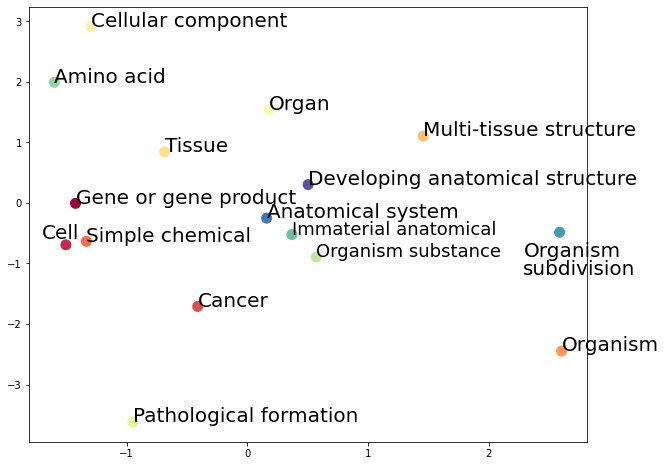

In [ ]:
#NOW DISPLAY POSITIVE AND (MAYBE) NEGATIVE VECS IN 2D SPACE !!
#PMAC paper: https://arxiv.org/abs/2012.04456
# https://pypi.org/project/pacmap/
#https://towardsdatascience.com/why-you-should-not-rely-on-t-sne-umap-or-trimap-f8f5dc333e59
# https://github.com/YingfanWang/PaCMAP

!pip install pacmap
# dataset that is in the ndarray format, with the shape (N, D)
# where N is the number of samples and D is the dimension of each sample
import pacmap

with_negatives=False

all_vecs4_2d_pos = [ positive_vecs[v] for v in positive_vecs ]
all_vecs4_2d_neg = [ negative_vecs[v] for v in negative_vecs ]
all_vecs4_2d_list = all_vecs4_2d_pos + all_vecs4_2d_neg
all_vecs4_2d_keys = [ v for v in positive_vecs ] + [v for v in negative_vecs]

all_vecs4_2d = np.stack(all_vecs4_2d_list)
all_vecs4_2d_pos_np = np.stack(all_vecs4_2d_pos)
all_vecs4_2d_neg_np = np.stack(all_vecs4_2d_neg)

X = all_vecs4_2d_pos_np
X2 = all_vecs4_2d_neg_np
#y = all_vecs4_2d_keys  #this should be colors
y = [ v for v in positive_vecs ] + [ i for i in range(12)]

t = np.arange(all_vecs4_2d_pos_np.shape[0])
#t2 = [1 for _ in range(11)] 

embedding = pacmap.PaCMAP(n_components=2, random_state=6) #n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(X, init="pca")

if with_negatives == False:
  fig, ax = plt.subplots(1, 1, figsize=(10, 8))  #10,8 with no negatives works fine for paper!
else:
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))  #10,8 with no negatives works fine for paper!

ax.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral", c=t, s=100)

fontsize = 14
for i in range(len(all_vecs4_2d_pos)):
  if y[i] == 'Cell':
    ax.annotate(y[i], (X_transformed[i, 0]-.2, X_transformed[i, 1]+.1), fontsize=20)
  elif y[i] == 'Organism_subdivision':
    ax.annotate('Organism', (X_transformed[i, 0]-.3, X_transformed[i, 1]-.4), fontsize=20)
    ax.annotate('subdivision', (X_transformed[i, 0]-.3, X_transformed[i, 1]-.7), fontsize=20)
  elif y[i] == 'Organism_substance':
    ax.annotate('Organism substance', (X_transformed[i, 0], X_transformed[i, 1]), fontsize=18)    
  elif y[i] == 'Immaterial_anatomical_entity':
    ax.annotate('Immaterial anatomical', (X_transformed[i, 0], X_transformed[i, 1]), fontsize=18)
  else:
    ax.annotate(y[i].replace("_"," "), (X_transformed[i, 0], X_transformed[i, 1]), fontsize=20)

if with_negatives:
  X2_transformed = embedding.fit_transform(X2, init="pca")

  for i in range(len(all_vecs4_2d_neg)):
    ax.scatter(X2_transformed[i, 0], X2_transformed[i, 1], cmap="Spectral", marker='x', c=t2[i], s=40)

  for i in range(len(all_vecs4_2d_neg)):
    ax.annotate(y[i+16], (X2_transformed[i, 0]+.05, X2_transformed[i, 1]),color='r')

  #ax.legend([i for i in range(12)],loc='upper right')
  ax.legend([str(i) +" " +v.replace("TRUE:",'').replace("\\n"," <- ").replace("PRED:","") for i,v in enumerate(negative_vecs)],loc='upper right')
print()

plt.savefig('positive_prototypes_fnt20_v2.pdf', bbox_inches="tight")  
# NOTE: USE this for paper ( it does show proximity for most common negatives ).. 
# and MAYBE compare against what you get if you use Dense CLS or output vecs?